# App Rating
* Important note:
* Any transformation we do should be contained in a function so we can reuse it later

## Download data from kaggle

In [9]:
import pandas as pd

train_df = pd.read_csv("app-rating-competition/train.csv")
test_df = pd.read_csv("app-rating-competition/test.csv")
sample_submission_df = pd.read_csv("app-rating-competition/SampleSubmission.csv")

## Data Exploration

In [10]:
train_df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,Coloring book moana,ART_AND_DESIGN,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,3.9
1,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7
2,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3
3,Paper flowers instructions,ART_AND_DESIGN,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4
4,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8


In [13]:
train_df

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,Coloring book moana,ART_AND_DESIGN,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,3.9
1,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7
2,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3
3,Paper flowers instructions,ART_AND_DESIGN,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4
4,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8963,FR Forms,BUSINESS,0,9.6M,10+,Free,0,Everyone,Business,"September 29, 2016",1.1.5,4.0 and up,NaN
8964,Sya9a Maroc - FR,FAMILY,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up,4.5
8965,Fr. Mike Schmitz Audio Teachings,FAMILY,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up,5.0
8966,Parkinson Exercices FR,MEDICAL,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up,NaN


### Column Observation
* X0 → App Name (Names)
    * Has duplicates
* X1 → App Category (Categorical)
    * Most frequent is FAMILY (1605)
    * 34 distinct categories
* X2 → Size in bytes probably (Numerical)
    * Could be used for weighted rating or normalization
* X3 → Downloads in millions (Numerical)
    * Has 1359 entries "Varies with device"
    * We might have to edit this with the app name duplicates
* X4 → Number of reviews (Categorical)
* X5 → Free/Paid (Categorical)
    * Has one null we should explore before handling
* X6 → Price if paid (Numerical)
    * Check for any free with price or any paid with 0
* X7 → Age Rating (Categorical)
    * 6 categories
    * Has a null value we should check before handling
    * Top is Everyone (7222)
* X8 → App Tags (Categorical) (Should be enhanced)
    * Most frequent is Tools (705)
* X9 → Release Date (Will be heavily feature extracted)
    * Month/Day/Year
    * Maybe convert to days (released on weekend etc.)
    * Could find if released on specific holidays (Christmas, etc.)
* X10 → App Version (I think) (Numerical or Categorical)
    * 7 null values
    * Top is "Varies with device" 1173
* X11 → Compatible OS version (I think) (Categorical)
    * 3 Null values
    * Top is "4.1 and up" (2072)
* Y → App Rating
    * 1474 Null values (should be cleaned)
    * Has outliers heavily

### Rename Columns

In [14]:
def rename_columns(dataframe):
    reformated_df = dataframe.rename(
        columns={"X0": "app_name", "X1": "app_category", "X2": "size_bytes", "X3": "downloads_millions",
                 "X4": "reviews_count", "X5": "free_paid", "X6": "price_if_paid", "X7": "age_rating",
                 "X8": "app_tags", "X9": "release_date", "X10": "app_version",
                 "X11": "compatible_os_version"})
    return reformated_df

In [60]:
train_df1 = rename_columns(train_df)
train_df1

,app_name,app_category,size_bytes,downloads_millions,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
0,Coloring book moana,ART_AND_DESIGN,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,3.9
1,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7
2,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3
3,Paper flowers instructions,ART_AND_DESIGN,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4
4,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8963,FR Forms,BUSINESS,0,9.6M,10+,Free,0,Everyone,Business,"September 29, 2016",1.1.5,4.0 and up,NaN
8964,Sya9a Maroc - FR,FAMILY,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up,4.5
8965,Fr. Mike Schmitz Audio Teachings,FAMILY,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up,5.0
8966,Parkinson Exercices FR,MEDICAL,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up,NaN


In [175]:
train_df_copy = train_df1.copy()

### Explore Null Values

#### Free/Paid nulls

In [176]:
train_df_copy[train_df_copy.free_paid.isnull()]

,app_name,app_category,size_bytes,downloads_millions,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
7533,Command & Conquer: Rivals,FAMILY,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device,NaN


* This has size 0, non-specific downloads, zero reviews, and null Y, so it sounds safe to drop
* Out of curiosity let's check if any other apps exist with the same name

In [177]:
train_df_copy[train_df_copy['app_name'].str.contains("conquer", case=False, na=False)]

,app_name,app_category,size_bytes,downloads_millions,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
7533,Command & Conquer: Rivals,FAMILY,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device,NaN


* So we will drop this

In [178]:
train_df_copy.dropna(subset=['free_paid'], inplace=True)  # drops column 7533

#### Age Rating Nulls

In [179]:
train_df_copy[train_df_copy.age_rating.isnull()]

,app_name,app_category,size_bytes,downloads_millions,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
8653,Life Made WI-Fi Touchscreen Photo Frame,1.9,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN,19.0


* It looks like this is perfectly ok, but the values of columns are switched around
* We can check for all distinct values from now to find any similar cases

In [180]:
train_df_copy.loc[8653]

app_name                 Life Made WI-Fi Touchscreen Photo Frame
app_category                                                 1.9
size_bytes                                                  3.0M
downloads_millions                                        1,000+
reviews_count                                               Free
free_paid                                                      0
price_if_paid                                           Everyone
age_rating                                                   NaN
app_tags                                       February 11, 2018
release_date                                              1.0.19
app_version                                           4.0 and up
compatible_os_version                                        NaN
Y                                                           19.0
Name: 8653, dtype: object

##### Real Values
* app_category: compatible_os_version
* size_bytes: Y
* downloads_millions: size_bytes
* reviews_count: downloads_millions
* free_paid: reviews_count
* price_if_paid: free_paid
* age_rating: price_if_paid
* app_tags: age_rating
* release_date: app_tags
* app_version: release_date
* compatible_os_version: app_version
* Y: app_category

In [181]:
swap_pairs = [
    ("app_category", "compatible_os_version"),
    ("size_bytes", "Y"),
    ("downloads_millions", "size_bytes"),
    ("reviews_count", "downloads_millions"),
    ("free_paid", "reviews_count"),
    ("price_if_paid", "free_paid"),
    ("age_rating", "price_if_paid"),
    ("app_tags", "age_rating"),
    ("release_date", "app_tags"),
    ("app_version", "release_date"),
    ("compatible_os_version", "app_version"),
    ("Y", "app_category"),
]

# First read all col2 values
values_to_copy = {
    col1: train_df_copy.at[8653, col2]
    for col1, col2 in swap_pairs
}

# Then write them all at once
for col1, value in values_to_copy.items():
    train_df_copy.at[8653, col1] = value



C:\Users\yousi\AppData\Local\Temp\ipykernel_62072\582722994.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  train_df_copy.at[8653, col1] = value


In [182]:
train_df_copy.loc[8653]

app_name                 Life Made WI-Fi Touchscreen Photo Frame
app_category                                                 NaN
size_bytes                                                  19.0
downloads_millions                                          3.0M
reviews_count                                             1,000+
free_paid                                                   Free
price_if_paid                                                  0
age_rating                                              Everyone
app_tags                                                     NaN
release_date                                   February 11, 2018
app_version                                               1.0.19
compatible_os_version                                 4.0 and up
Y                                                            1.9
Name: 8653, dtype: object

* The row is still not fully clean
* Also I'm not sure 19.0 is possible in size as other sizes aren't in float
* And not sure rating is real
* Category and tags are null but they can be easily found online
* We will drop this for now but save it

In [183]:
dropped_row_8653 = train_df_copy.loc[[8653]]

train_df_copy.drop(8653, inplace=True)
dropped_row_8653

,app_name,app_category,size_bytes,downloads_millions,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
8653,Life Made WI-Fi Touchscreen Photo Frame,NaN,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,1.9


#### App Version Nulls

In [184]:
train_df_copy[train_df_copy.app_version.isnull()]

,app_name,app_category,size_bytes,downloads_millions,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
10,Learn To Draw Kawaii Characters,ART_AND_DESIGN,55,2.7M,"5,000+",Free,0,Everyone,Art & Design,"June 6, 2018",NaN,4.2 and up,3.2
1257,Market Update Helper,LIBRARIES_AND_DEMO,20145,11k,"1,000,000+",Free,0,Everyone,Libraries & Demo,"February 12, 2013",NaN,1.5 and up,4.1
5160,Virtual DJ Sound Mixer,TOOLS,4010,8.7M,"500,000+",Free,0,Everyone,Tools,"May 10, 2017",NaN,4.0 and up,4.2
5570,BT Master,FAMILY,0,222k,100+,Free,0,Everyone,Education,"November 6, 2016",NaN,1.6 and up,NaN
6082,Calculate My IQ,FAMILY,44,7.2M,"10,000+",Free,0,Everyone,Entertainment,"April 3, 2017",NaN,2.3 and up,NaN
6350,UFO-CQ,TOOLS,1,237k,10+,Paid,$0.99,Everyone,Tools,"July 4, 2016",NaN,2.0 and up,NaN
8541,La Fe de Jesus,BOOKS_AND_REFERENCE,8,658k,"1,000+",Free,0,Everyone,Books & Reference,"January 31, 2017",NaN,3.0 and up,NaN


* Turns out downloads are not only in millions, so let's edit the name, and we will solve this later
* I don't know what the size is in; it wouldn't make sense for it to be bytes, so let's check later
* Also notice the last four rows have null ratings as well
* But the rest have valid columns, so we could drop the last 4 for now and come up with app_version values for the rest

In [185]:
dropped_rows_null_version_rating = train_df_copy[
    train_df_copy[['app_version', 'Y']].isnull().all(axis=1)
]
dropped_rows_null_version_rating

,app_name,app_category,size_bytes,downloads_millions,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
5570,BT Master,FAMILY,0,222k,100+,Free,0,Everyone,Education,"November 6, 2016",NaN,1.6 and up,NaN
6082,Calculate My IQ,FAMILY,44,7.2M,"10,000+",Free,0,Everyone,Entertainment,"April 3, 2017",NaN,2.3 and up,NaN
6350,UFO-CQ,TOOLS,1,237k,10+,Paid,$0.99,Everyone,Tools,"July 4, 2016",NaN,2.0 and up,NaN
8541,La Fe de Jesus,BOOKS_AND_REFERENCE,8,658k,"1,000+",Free,0,Everyone,Books & Reference,"January 31, 2017",NaN,3.0 and up,NaN


In [186]:
train_df_copy.drop(dropped_rows_null_version_rating.index, inplace=True)
train_df_copy[train_df_copy.app_version.isnull()]

,app_name,app_category,size_bytes,downloads_millions,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
10,Learn To Draw Kawaii Characters,ART_AND_DESIGN,55,2.7M,"5,000+",Free,0,Everyone,Art & Design,"June 6, 2018",NaN,4.2 and up,3.2
1257,Market Update Helper,LIBRARIES_AND_DEMO,20145,11k,"1,000,000+",Free,0,Everyone,Libraries & Demo,"February 12, 2013",NaN,1.5 and up,4.1
5160,Virtual DJ Sound Mixer,TOOLS,4010,8.7M,"500,000+",Free,0,Everyone,Tools,"May 10, 2017",NaN,4.0 and up,4.2


* Now rename columns as stated

In [187]:
train_df_copy.rename(columns={
    'size_bytes': 'size_unknown_unit',
    'downloads_millions': 'downloads_unstandardized'
}, inplace=True)
train_df_copy.head()


,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
0,Coloring book moana,ART_AND_DESIGN,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,3.9
1,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7
2,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3
3,Paper flowers instructions,ART_AND_DESIGN,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4
4,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8


#### Compatible OS Nulls

In [188]:
train_df_copy[train_df_copy.compatible_os_version.isnull()]

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
3599,[substratum] Vacuum: P,PERSONALIZATION,230,11M,"1,000+",Paid,$1.49,Everyone,Personalization,"July 20, 2018",4.4,NaN,4.4
3630,Pi Dark [substratum],PERSONALIZATION,189,2.1M,"10,000+",Free,0,Everyone,Personalization,"March 27, 2018",1.1,NaN,4.5


* substratum is a theme engine for android to allow users to set themes to their phone
* Pi Dark is 2MB in the play store, so the unit we have still doesn't make sense
* I'm not sure if we should drop these, so we'll leave them for now
* Let's look at any other substratum

In [189]:
train_df_copy[train_df_copy['app_name'].str.contains("substratum", case=False, na=False)]

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
3459,J Dark Ice Substratum Theme,PERSONALIZATION,164,33M,"10,000+",Free,0,Everyone,Personalization,"July 19, 2018",4.3,6.0 and up,4.5
3558,Dark Infusion Substratum Theme for Android N & O,PERSONALIZATION,133,59M,"1,000+",Paid,$2.49,Everyone,Personalization,"August 3, 2018",15.6,7.0 and up,4.8
3599,[substratum] Vacuum: P,PERSONALIZATION,230,11M,"1,000+",Paid,$1.49,Everyone,Personalization,"July 20, 2018",4.4,NaN,4.4
3630,Pi Dark [substratum],PERSONALIZATION,189,2.1M,"10,000+",Free,0,Everyone,Personalization,"March 27, 2018",1.1,NaN,4.5
3707,PitchBlack S - Samsung Substratum Theme “For O...,PERSONALIZATION,90,37M,"1,000+",Paid,$1.99,Everyone,Personalization,"August 4, 2018",12.6,7.0 and up,4.5
5442,[Substratum] M5 Theme,PERSONALIZATION,16,6.7M,"5,000+",Free,0,Everyone,Personalization,"March 10, 2018",1.3.4,7.0 and up,4.4


* All substratum themes have almost the same compatible_os_version as either 6.0 and up or 7.0 and up
* So we can fill our null values using this
* I will set both as 7.0 and up since it is most common

In [190]:
train_df_copy.fillna(value={"compatible_os_version": "7.0 and up"}, inplace=True)
train_df_copy[train_df_copy['app_name'].str.contains("substratum", case=False, na=False)]

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
3459,J Dark Ice Substratum Theme,PERSONALIZATION,164,33M,"10,000+",Free,0,Everyone,Personalization,"July 19, 2018",4.3,6.0 and up,4.5
3558,Dark Infusion Substratum Theme for Android N & O,PERSONALIZATION,133,59M,"1,000+",Paid,$2.49,Everyone,Personalization,"August 3, 2018",15.6,7.0 and up,4.8
3599,[substratum] Vacuum: P,PERSONALIZATION,230,11M,"1,000+",Paid,$1.49,Everyone,Personalization,"July 20, 2018",4.4,7.0 and up,4.4
3630,Pi Dark [substratum],PERSONALIZATION,189,2.1M,"10,000+",Free,0,Everyone,Personalization,"March 27, 2018",1.1,7.0 and up,4.5
3707,PitchBlack S - Samsung Substratum Theme “For O...,PERSONALIZATION,90,37M,"1,000+",Paid,$1.99,Everyone,Personalization,"August 4, 2018",12.6,7.0 and up,4.5
5442,[Substratum] M5 Theme,PERSONALIZATION,16,6.7M,"5,000+",Free,0,Everyone,Personalization,"March 10, 2018",1.3.4,7.0 and up,4.4


#### App Rating nulls

In [191]:
train_df_copy[train_df_copy.Y.isnull()]

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
16,Mcqueen Coloring pages,ART_AND_DESIGN,61,7.0M,"100,000+",Free,0,Everyone,Art & Design;Action & Adventure,"March 7, 2018",1.0.0,4.1 and up,NaN
79,Wrinkles and rejuvenation,BEAUTY,182,5.7M,"100,000+",Free,0,Everyone 10+,Beauty,"September 20, 2017",8.0,3.0 and up,NaN
87,Manicure - nail design,BEAUTY,119,3.7M,"50,000+",Free,0,Everyone,Beauty,"July 23, 2018",1.3,4.1 and up,NaN
90,Skin Care and Natural Beauty,BEAUTY,654,7.4M,"100,000+",Free,0,Teen,Beauty,"July 17, 2018",1.15,4.1 and up,NaN
93,"Secrets of beauty, youth and health",BEAUTY,77,2.9M,"10,000+",Free,0,Mature 17+,Beauty,"August 8, 2017",2.0,2.3 and up,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8954,Cardio-FR,MEDICAL,67,82M,"10,000+",Free,0,Everyone,Medical,"July 31, 2018",2.2.2,4.4 and up,NaN
8955,Naruto & Boruto FR,SOCIAL,7,7.7M,100+,Free,0,Teen,Social,"February 2, 2018",1.0,4.0 and up,NaN
8960,payermonstationnement.fr,MAPS_AND_NAVIGATION,38,9.8M,"5,000+",Free,0,Everyone,Maps & Navigation,"June 13, 2018",2.0.148.0,4.0 and up,NaN
8963,FR Forms,BUSINESS,0,9.6M,10+,Free,0,Everyone,Business,"September 29, 2016",1.1.5,4.0 and up,NaN


In [192]:
train_df_copy.Y.isnull().sum()

np.int64(1469)

* We have 1469 nulls which is too much to handle, so we can return to this later after more cleaning

### Explore Data Types
* Data types for a column should be consistent, so we should look for inconsistent rows and clean them

In [193]:
train_df_copy.dtypes

app_name                    object
app_category                object
size_unknown_unit           object
downloads_unstandardized    object
reviews_count               object
free_paid                   object
price_if_paid               object
age_rating                  object
app_tags                    object
release_date                object
app_version                 object
compatible_os_version       object
Y                           object
dtype: object

* Let's check for individual columns types as well as all unique values where possible

#### App Name

In [194]:
train_df_copy['app_name'].map(type).value_counts()


app_name
<class 'str'>    8962
Name: count, dtype: int64

In [195]:
train_df_copy['app_name'].value_counts()

app_name
ROBLOX                                               8
CBS Sports App - Scores, News, Stats & Watch Live    7
8 Ball Pool                                          6
Temple Run 2                                         6
Helix Jump                                           6
                                                    ..
FieldBi FR Offline                                   1
Golden Dictionary (FR-AR)                            1
FR: My Secret Pets!                                  1
DICT.fr Mobile                                       1
Fr Agnel Pune                                        1
Name: count, Length: 8154, dtype: int64

* Duplicated Names could cause a problem, we'll check later

#### App Category

In [196]:
train_df_copy['app_category'].map(type).value_counts()

app_category
<class 'str'>    8962
Name: count, dtype: int64

In [197]:
train_df_copy['app_category'].value_counts()

app_category
FAMILY                 1602
GAME                    929
TOOLS                   705
BUSINESS                403
MEDICAL                 395
PRODUCTIVITY            346
PERSONALIZATION         334
COMMUNICATION           334
SPORTS                  316
LIFESTYLE               315
FINANCE                 298
HEALTH_AND_FITNESS      287
PHOTOGRAPHY             278
SOCIAL                  251
NEWS_AND_MAGAZINES      249
SHOPPING                212
TRAVEL_AND_LOCAL        202
DATING                  192
BOOKS_AND_REFERENCE     187
VIDEO_PLAYERS           144
ENTERTAINMENT           126
EDUCATION               125
MAPS_AND_NAVIGATION     117
FOOD_AND_DRINK          102
HOUSE_AND_HOME           72
AUTO_AND_VEHICLES        71
LIBRARIES_AND_DEMO       70
WEATHER                  66
EVENTS                   56
ART_AND_DESIGN           49
PARENTING                44
COMICS                   43
BEAUTY                   42
Name: count, dtype: int64

#### Size

In [198]:
train_df_copy['size_unknown_unit'].map(type).value_counts()

size_unknown_unit
<class 'str'>    8962
Name: count, dtype: int64

In [199]:
train_df_copy['size_unknown_unit'].value_counts()

size_unknown_unit
0         594
1         262
2         192
3         161
4         118
         ... 
36815       1
87510       1
398307      1
455         1
1035        1
Name: count, Length: 5006, dtype: int64

* Apps with size 0 could cause a problem, so check later
* Also, size shouldn't be string unless we turn it categorical (<100, <10, etc.)

#### Downloads

In [200]:
train_df_copy['downloads_unstandardized'].map(type).value_counts()

downloads_unstandardized
<class 'str'>    8962
Name: count, dtype: int64

In [201]:
train_df_copy['downloads_unstandardized'].value_counts()

downloads_unstandardized
Varies with device    1358
12M                    174
11M                    157
14M                    157
13M                    152
                      ... 
404k                     1
420k                     1
992k                     1
73k                      1
518k                     1
Name: count, Length: 414, dtype: int64

* Varies with device could cause a problem, but we should turn this numerical.
* We only have numbers in millions (M) and thousands (K), so we should standardize

#### Reviews Number

In [202]:
train_df_copy['reviews_count'].map(type).value_counts()

reviews_count
<class 'str'>    8962
Name: count, dtype: int64

In [203]:
train_df_copy['reviews_count'].value_counts()

reviews_count
1,000,000+        1265
10,000,000+        991
100,000+           932
10,000+            868
1,000+             751
100+               656
5,000,000+         604
500,000+           447
5,000+             388
50,000+            386
10+                368
100,000,000+       337
500+               283
50,000,000+        229
50+                195
5+                  78
1+                  67
500,000,000+        57
1,000,000,000+      46
0+                  14
Name: count, dtype: int64

* Looks fine but we should try it as categorical and numerical

#### Free/Paid

In [204]:
train_df_copy['free_paid'].map(type).value_counts()

free_paid
<class 'str'>    8962
Name: count, dtype: int64

In [205]:
train_df_copy['free_paid'].value_counts()

free_paid
Free    8298
Paid     664
Name: count, dtype: int64

* Looks fine and will be categorical
* Let's look at any incorrect mappings (free but has price, paid but price 0

#### Price if paid

In [206]:
train_df_copy['price_if_paid'].map(type).value_counts()

price_if_paid
<class 'str'>    8962
Name: count, dtype: int64

In [207]:
train_df_copy['price_if_paid'].value_counts()

price_if_paid
0          8298
$0.99       124
$2.99        99
$1.99        64
$4.99        60
           ... 
$3.61         1
$394.99       1
$1.26         1
$1.20         1
$1.04         1
Name: count, Length: 86, dtype: int64

In [208]:
inconsistent_price_rows = train_df_copy[
    ((train_df_copy['free_paid'] == "Free") & (train_df_copy['price_if_paid'] != "0")) |
    ((train_df_copy['free_paid'] == "Paid") & (
            (train_df_copy['price_if_paid'] == "0") | (train_df_copy['price_if_paid'].isnull())))
    ]
inconsistent_price_rows

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y


* Looks fine, we should remove the dollar sign to make it numerical
* Maybe try price tiers categories
* We also have no inconsistent prices

#### Age Rating

In [209]:
train_df_copy['age_rating'].map(type).value_counts()

age_rating
<class 'str'>    8962
Name: count, dtype: int64

In [210]:
train_df_copy['age_rating'].value_counts()

age_rating
Everyone           7218
Teen               1000
Mature 17+          406
Everyone 10+        333
Adults only 18+       3
Unrated               2
Name: count, dtype: int64

* Looks fine maybe clean up the string

#### App Tags

In [211]:
train_df_copy['app_tags'].map(type).value_counts()

app_tags
<class 'str'>    8962
Name: count, dtype: int64

In [212]:
train_df_copy['app_tags'].value_counts()

app_tags
Tools                       704
Entertainment               528
Education                   453
Business                    403
Medical                     395
                           ... 
Role Playing;Brain Games      1
Racing;Pretend Play           1
Puzzle;Creativity             1
Communication;Creativity      1
Strategy;Creativity           1
Name: count, Length: 114, dtype: int64

* This is currently too much and will need cleaning

#### Release Date

In [213]:
train_df_copy['release_date'].map(type).value_counts()

release_date
<class 'str'>    8962
Name: count, dtype: int64

In [214]:
train_df_copy['release_date'].value_counts()

release_date
August 3, 2018       249
August 2, 2018       248
July 31, 2018        237
August 1, 2018       230
July 30, 2018        170
                    ... 
March 7, 2014          1
December 18, 2013      1
February 27, 2015      1
January 29, 2016       1
June 17, 2012          1
Name: count, Length: 1299, dtype: int64

In [215]:
expected_format = "%B %d, %Y"

invalid_dates = pd.to_datetime(
    train_df_copy['release_date'],
    format=expected_format,
    errors='coerce'  # Converts invalid formats to NaT (null)
).isna()

invalid_date_rows = train_df_copy[invalid_dates]
invalid_date_rows

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y


* All date rows are consistent in format
* However, this current release date will not help and will need to be extracted to more useful features

#### App Version

In [216]:
train_df_copy['app_version'].map(type).value_counts()

app_version
<class 'str'>      8959
<class 'float'>       3
Name: count, dtype: int64

In [217]:
train_df_copy['app_version'].value_counts()

app_version
Varies with device    1172
1.0                    714
1.1                    220
1.2                    149
2.0                    126
                      ... 
3.36                     1
Android 3.0 - 2017       1
2.1.9f7                  1
4.6.1404                 1
4.7.0.2200000            1
Name: count, Length: 2502, dtype: int64

* Again varies with device is causing a problem here
* And we want to standardize the type here

In [218]:
train_df_copy[train_df_copy['app_version'].map(type) == float]

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
10,Learn To Draw Kawaii Characters,ART_AND_DESIGN,55,2.7M,"5,000+",Free,0,Everyone,Art & Design,"June 6, 2018",NaN,4.2 and up,3.2
1257,Market Update Helper,LIBRARIES_AND_DEMO,20145,11k,"1,000,000+",Free,0,Everyone,Libraries & Demo,"February 12, 2013",NaN,1.5 and up,4.1
5160,Virtual DJ Sound Mixer,TOOLS,4010,8.7M,"500,000+",Free,0,Everyone,Tools,"May 10, 2017",NaN,4.0 and up,4.2


In [219]:
dropped_rows_null_version = train_df_copy[
    train_df_copy[['app_version']].isnull().all(axis=1)
]
dropped_rows_null_version

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
10,Learn To Draw Kawaii Characters,ART_AND_DESIGN,55,2.7M,"5,000+",Free,0,Everyone,Art & Design,"June 6, 2018",NaN,4.2 and up,3.2
1257,Market Update Helper,LIBRARIES_AND_DEMO,20145,11k,"1,000,000+",Free,0,Everyone,Libraries & Demo,"February 12, 2013",NaN,1.5 and up,4.1
5160,Virtual DJ Sound Mixer,TOOLS,4010,8.7M,"500,000+",Free,0,Everyone,Tools,"May 10, 2017",NaN,4.0 and up,4.2


In [220]:
train_df_copy.dropna(subset=['app_version'], inplace=True)

* We'll drop these rows for now

#### Compatible OS

In [221]:
train_df_copy['compatible_os_version'].map(type).value_counts()

compatible_os_version
<class 'str'>    8959
Name: count, dtype: int64

In [222]:
train_df_copy['compatible_os_version'].value_counts()

compatible_os_version
4.1 and up            2072
4.0.3 and up          1228
4.0 and up            1124
Varies with device    1087
4.4 and up             817
2.3 and up             515
5.0 and up             508
4.2 and up             329
2.3.3 and up           234
2.2 and up             206
3.0 and up             203
4.3 and up             201
2.1 and up             113
1.6 and up              93
6.0 and up              54
7.0 and up              38
3.2 and up              34
2.0 and up              24
5.1 and up              18
1.5 and up              16
4.4W and up             12
3.1 and up              10
2.0.1 and up             6
8.0 and up               5
7.1 and up               3
4.0.3 - 7.1.1            2
7.0 - 7.1.1              1
5.0 - 8.0                1
4.1 - 7.1.1              1
5.0 - 6.0                1
1.0 and up               1
2.2 - 7.1.1              1
5.0 - 7.1.1              1
Name: count, dtype: int64

* Again varies with device
* Also some fields have "5.0 and up" format and others have "5.0 - 7.1.1" format, we should explore these formats

#### App Rating

In [223]:
train_df_copy['Y'].map(type).value_counts()

Y
<class 'float'>    8959
Name: count, dtype: int64

In [224]:
train_df_copy['Y'].value_counts()

Y
4.4    891
4.3    881
4.5    840
4.2    748
4.6    658
4.1    575
4.0    439
4.7    385
3.9    304
3.8    244
5.0    207
3.7    196
4.8    177
3.6    143
3.5    131
3.4    104
3.3     83
4.9     74
3.0     62
3.1     55
3.2     53
2.8     36
2.9     34
2.6     24
2.7     21
2.5     18
2.4     15
1.0     14
2.3     13
1.9     12
2.2     12
2.0     11
2.1      8
1.8      7
1.7      6
1.6      4
1.4      3
1.2      1
1.5      1
Name: count, dtype: int64

### Handling Duplicates

#### Duplicate Names

In [225]:
train_df_copy['app_name'].value_counts()

app_name
ROBLOX                                                8
CBS Sports App - Scores, News, Stats & Watch Live     7
Temple Run 2                                          6
slither.io                                            6
Zombie Catchers                                       6
                                                     ..
FR Forms                                              1
Sya9a Maroc - FR                                      1
Fr. Mike Schmitz Audio Teachings                      1
Parkinson Exercices FR                                1
U Launcher Lite – FREE Live Cool Themes, Hide Apps    1
Name: count, Length: 8151, dtype: int64

In [226]:
roblox_rows = train_df_copy[train_df_copy['app_name'] == "ROBLOX"]
roblox_rows

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
1334,ROBLOX,GAME,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5
1370,ROBLOX,GAME,4447346,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5
1409,ROBLOX,GAME,4448791,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5
1480,ROBLOX,GAME,4449882,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5
1502,ROBLOX,GAME,4449910,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5
1627,ROBLOX,FAMILY,4449910,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5
1780,ROBLOX,FAMILY,4450890,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5
3663,ROBLOX,FAMILY,4443407,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5


* These are duplicates, we will turn them to 1 and use the GAME tag as its the median
* We will get the mean size as it's different

In [227]:
app_category_median = roblox_rows['app_category'].mode()[0]

app_category_median

'GAME'

In [228]:
size_mean = pd.to_numeric(roblox_rows['size_unknown_unit'], errors='coerce').mean()

size_mean

np.float64(4448440.5)

In [229]:
def drop_duplicates_specific_value(dataframe, column_name, value_name):
    is_column = dataframe[column_name] == value_name
    column_deduped = dataframe[is_column].drop_duplicates(subset=column_name, keep='first')

    non_column = dataframe[~is_column]

    return pd.concat([non_column, column_deduped], ignore_index=True)


In [232]:
train_df_copy = drop_duplicates_specific_value(train_df_copy, 'app_name', 'ROBLOX')
train_df_copy[train_df_copy['app_name'] == "ROBLOX"]

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
8951,ROBLOX,GAME,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5


In [233]:
import math

roblox_size_floored_str = str(math.floor(size_mean))
roblox_size_floored_str

'4448440'

In [234]:
train_df_copy.loc[train_df_copy['app_name'] == "ROBLOX", 'size_unknown_unit'] = roblox_size_floored_str
train_df_copy[train_df_copy['app_name'] == "ROBLOX"]

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
8951,ROBLOX,GAME,4448440,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up,4.5


* Let's now handle other duplicates

In [235]:
train_df_copy['app_name'].value_counts()

app_name
CBS Sports App - Scores, News, Stats & Watch Live     7
slither.io                                            6
Temple Run 2                                          6
8 Ball Pool                                           6
Helix Jump                                            6
                                                     ..
Sya9a Maroc - FR                                      1
Fr. Mike Schmitz Audio Teachings                      1
Parkinson Exercices FR                                1
iHoroscope - 2018 Daily Horoscope & Astrology         1
U Launcher Lite – FREE Live Cool Themes, Hide Apps    1
Name: count, Length: 8151, dtype: int64

#### Drop perfect duplicates
* Let's drop perfect duplicates first (all columns equal)

In [239]:
train_df_copy_checkpoint = train_df_copy.copy()

In [240]:
train_df_copy.drop_duplicates(inplace=True)
train_df_copy['app_name'].value_counts()

app_name
Helix Jump                                            6
Zombie Catchers                                       6
8 Ball Pool                                           6
Angry Birds Classic                                   5
Temple Run 2                                          5
                                                     ..
Sya9a Maroc - FR                                      1
Fr. Mike Schmitz Audio Teachings                      1
Parkinson Exercices FR                                1
iHoroscope - 2018 Daily Horoscope & Astrology         1
U Launcher Lite – FREE Live Cool Themes, Hide Apps    1
Name: count, Length: 8151, dtype: int64

#### Duplicates w/ different sizes
* We still have duplicates, so we will handle them in different ways
* Let's first check for duplicates with different sizes only

In [245]:
def find_near_duplicates(df, except_col):
    columns_except = df.columns.difference([except_col])
    near_duplicates = df[df.duplicated(subset=columns_except, keep=False)]
    return near_duplicates


# Define columns to check for duplicates (exclude 'size_unknown_unit')
columns_except_size = train_df_copy.columns.difference(['size_unknown_unit'])

# Find duplicates based on all columns except size
near_duplicates = find_near_duplicates(train_df_copy, except_col='size_unknown_unit')
near_duplicates

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
28,Textgram - write on photos,ART_AND_DESIGN,295221,Varies with device,"10,000,000+",Free,0,Everyone,Art & Design,"July 30, 2018",Varies with device,Varies with device,4.4
104,Amazon Kindle,BOOKS_AND_REFERENCE,814080,Varies with device,"100,000,000+",Free,0,Teen,Books & Reference,"July 27, 2018",Varies with device,Varies with device,4.2
117,Spanish English Translator,BOOKS_AND_REFERENCE,87873,Varies with device,"10,000,000+",Free,0,Teen,Books & Reference,"May 28, 2018",Varies with device,Varies with device,4.2
122,NOOK App for NOOK Devices,BOOKS_AND_REFERENCE,19080,Varies with device,"500,000+",Free,0,Everyone,Books & Reference,"April 25, 2018",Varies with device,Varies with device,4.7
142,English Dictionary - Offline,BOOKS_AND_REFERENCE,341157,30M,"10,000,000+",Free,0,Everyone 10+,Books & Reference,"March 20, 2018",3.9.1,4.2 and up,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,Who Viewed My Facebook Profile - Stalkers Visi...,SOCIAL,273244,9.9M,"5,000,000+",Free,0,Everyone,Social,"June 24, 2018",4.1.1,4.0.3 and up,4.6
8784,Podcast App: Free & Offline Podcasts by Player FM,NEWS_AND_MAGAZINES,66407,19M,"1,000,000+",Free,0,Teen,News & Magazines,"July 25, 2018",4.1.0.72,4.0 and up,4.6
8843,FarmersOnly Dating,DATING,1145,1.4M,"100,000+",Free,0,Mature 17+,Dating,"February 25, 2016",2.2,4.0 and up,3.0
8846,Firefox Focus: The privacy browser,COMMUNICATION,36981,4.0M,"1,000,000+",Free,0,Everyone,Communication,"July 6, 2018",5.2,5.0 and up,4.4


* We will now take the mean size and drop duplicates and use the floored mean
* This is a helper function that we can use later

In [246]:
def deduplicate_with_aggregation(dataframe, group_by_except_col, target_col, strategy, key_col):
    """
    Deduplicates rows that are equal in all columns except one,
    aggregates the target column using a given strategy, and
    keeps only one row per duplicate group with the updated value.

    Parameters:
    - dataframe: pd.DataFrame
    - group_by_except_col: str → the column to ignore when checking for duplicates
    - target_col: str → the column to aggregate and update (usually same as group_by_except_col)
    - strategy: str → 'mean', 'median', or 'mode'
    - key_col: str → the column to identify duplicate groups (default 'app_name')

    Returns:
    - Cleaned DataFrame with duplicates dropped and target_col updated.
    """

    group_cols = dataframe.columns.difference([group_by_except_col])
    duplicate_rows = dataframe[dataframe.duplicated(subset=group_cols, keep=False)]
    grouped = duplicate_rows.groupby(list(group_cols))

    for _, group_df in grouped:
        # Aggregate value based on strategy
        values = group_df[target_col].dropna()

        if strategy == 'mean':
            result = pd.to_numeric(values, errors='coerce').mean()
            aggregated_value = str(math.floor(result)) if pd.notna(result) else None

        elif strategy == 'median':
            result = pd.to_numeric(values, errors='coerce').median()
            aggregated_value = str(math.floor(result)) if pd.notna(result) else None

        elif strategy == 'mode':
            mode_vals = values.mode()
            aggregated_value = str(mode_vals[0]) if not mode_vals.empty else None

        else:
            raise ValueError(f"Unsupported strategy: {strategy}")

        # Representative key value for filtering
        key_value = group_df[key_col].iloc[0]

        # Drop duplicates of this key
        dataframe = drop_duplicates_specific_value(dataframe, key_col, key_value)

        # Assign new value if available
        if aggregated_value is not None:
            dataframe.loc[dataframe[key_col] == key_value, target_col] = aggregated_value

    return dataframe


In [249]:
train_df_copy = deduplicate_with_aggregation(
    train_df_copy,
    group_by_except_col='size_unknown_unit',
    target_col='size_unknown_unit',
    strategy='mean',
    key_col='app_name'
)

find_near_duplicates(train_df_copy, except_col='size_unknown_unit')

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y


#### Duplicates w/ different categories

* Let's first check if this has helped any of our other cases

In [253]:
train_df_copy.Y.isnull().sum()

np.int64(1460)

In [255]:
(train_df_copy['compatible_os_version'] == "Varies with device").sum()

np.int64(859)

In [256]:
(train_df_copy['app_version'] == "Varies with device").sum()

np.int64(920)

In [258]:
(train_df_copy['downloads_unstandardized'] == "Varies with device").sum()

np.int64(1062)

* Null Y: 1469 -> 1460
* OS varies: 1087 -> 859
* App version varies: 1172 -> 920
* downloads varies: 1358 -> 1062
* Let's now find duplicates with different category

In [259]:
find_near_duplicates(train_df_copy, except_col='app_category')

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
467,Learn C++,EDUCATION,73404,5.3M,"1,000,000+",Free,0,Everyone,Education,"December 25, 2017",4.5.2,4.0 and up,4.6
509,Fuzzy Numbers: Pre-K Number Foundation,EDUCATION,21,44M,"1,000+",Paid,$5.99,Everyone,Education;Education,"July 21, 2017",1.3,4.1 and up,4.7
1127,Candy Bomb,GAME,42145,20M,"10,000,000+",Free,0,Everyone,Casual;Brain Games,"July 4, 2018",2.9.3181,4.0.3 and up,4.4
1140,Candy Bomb,FAMILY,42145,20M,"10,000,000+",Free,0,Everyone,Casual;Brain Games,"July 4, 2018",2.9.3181,4.0.3 and up,4.4
2362,Learn C++,FAMILY,73404,5.3M,"1,000,000+",Free,0,Everyone,Education,"December 25, 2017",4.5.2,4.0 and up,4.6
2563,Fuzzy Numbers: Pre-K Number Foundation,FAMILY,21,44M,"1,000+",Paid,$5.99,Everyone,Education;Education,"July 21, 2017",1.3,4.1 and up,4.7


* Using a median wouldn't apply here as we only have two values for each
* However, looking at the tags and name we can decide which category is most suitable
* Learn C++: EDUCATION
* Fuzzy Numbers: EDUCATION
* Candy Bomb: GAME

In [261]:
train_df_copy.loc[train_df_copy['app_name'] == "Learn C++", 'app_category'] = "EDUCATION"
train_df_copy.loc[train_df_copy['app_name'] == "Fuzzy Numbers: Pre-K Number Foundation", 'app_category'] = "EDUCATION"
train_df_copy.loc[train_df_copy['app_name'] == "Candy Bomb", 'app_category'] = "GAME"
train_df_copy.drop_duplicates(inplace=True)
find_near_duplicates(train_df_copy, except_col='app_category')

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y


#### Duplicates w/ different release date
* Only other near duplicates are release date

In [267]:
find_near_duplicates(train_df_copy, except_col='release_date')

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
1573,Target - now with Cartwheel,SHOPPING,68406,24M,"10,000,000+",Free,0,Everyone,Shopping,"July 25, 2018",6.25.0+1906001476,5.0 and up,4.1
1621,Target - now with Cartwheel,SHOPPING,68406,24M,"10,000,000+",Free,0,Everyone,Shopping,"August 6, 2018",6.25.0+1906001476,5.0 and up,4.1
1922,osmino Wi-Fi: free WiFi,TOOLS,134203,4.1M,"10,000,000+",Free,0,Everyone,Tools,"August 6, 2018",6.06.14,4.4 and up,4.2
7579,osmino Wi-Fi: free WiFi,TOOLS,134203,4.1M,"10,000,000+",Free,0,Everyone,Tools,"August 7, 2018",6.06.14,4.4 and up,4.2


* Again we will set this manually
* osmino Wi-Fi: free WiFi: August 6, 2018
* Target - now with Cartwheel:  July 25, 2018

In [272]:
train_df_copy.loc[train_df_copy['app_name'] == "Target - now with Cartwheel", 'release_date'] = "July 25, 2018"
train_df_copy.loc[train_df_copy['app_name'] == "osmino Wi-Fi: free WiFi", 'release_date'] = "August 6, 2018"
train_df_copy.drop_duplicates(inplace=True)
find_near_duplicates(train_df_copy, except_col='release_date')

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y


#### Duplicate Names Check

In [274]:
train_df_copy['app_name'].value_counts()

app_name
Video Editor                                          3
Solitaire                                             3
Angry Birds 2                                         2
AccuWeather: Daily Forecast & Live Weather Reports    2
Flipkart Online Shopping App                          2
                                                     ..
ASOS                                                  1
Booking.com Travel Deals                              1
Bowmasters                                            1
Wordscapes                                            1
U Launcher Lite – FREE Live Cool Themes, Hide Apps    1
Name: count, Length: 8151, dtype: int64

In [275]:
app_names_with_3 = train_df_copy['app_name'].value_counts()
app_names_with_3 = app_names_with_3[app_names_with_3 == 3].index
rows_with_3_duplicates = train_df_copy[train_df_copy['app_name'].isin(app_names_with_3)]
rows_with_3_duplicates

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
1024,Solitaire,GAME,254258,23M,"10,000,000+",Free,0,Everyone,Card,"August 1, 2018",2.137.0,4.1 and up,4.7
1124,Solitaire,GAME,154264,12M,"10,000,000+",Free,0,Everyone,Card,"June 8, 2018",Varies with device,Varies with device,4.7
1146,Solitaire,FAMILY,685,26M,"100,000+",Free,0,Everyone,Card;Brain Games,"July 16, 2018",1.7.101,4.1 and up,4.4
1273,Video Editor,FAMILY,159619,23M,"5,000,000+",Free,0,Everyone,Video Players & Editors;Creativity,"July 17, 2018",6.14.091,4.3 and up,4.1
2175,Video Editor,VIDEO_PLAYERS,159622,23M,"5,000,000+",Free,0,Everyone,Video Players & Editors;Creativity,"July 17, 2018",6.14.091,4.3 and up,4.1
3745,Video Editor,VIDEO_PLAYERS,1156,23M,"100,000+",Free,0,Everyone,Video Players & Editors,"October 20, 2015",1.3.9b,4.3 and up,3.8


* Most of these make sense other than the video editor which has 2 duplicates from the 3

In [276]:
train_df_copy.loc[
    (train_df_copy['app_name'] == "Video Editor") &
    (train_df_copy['reviews_count'] == "5,000,000+"),
    'app_category'
] = "VIDEO_PLAYERS"

rows_with_3_duplicates = train_df_copy[train_df_copy['app_name'].isin(app_names_with_3)]
rows_with_3_duplicates

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
1024,Solitaire,GAME,254258,23M,"10,000,000+",Free,0,Everyone,Card,"August 1, 2018",2.137.0,4.1 and up,4.7
1124,Solitaire,GAME,154264,12M,"10,000,000+",Free,0,Everyone,Card,"June 8, 2018",Varies with device,Varies with device,4.7
1146,Solitaire,FAMILY,685,26M,"100,000+",Free,0,Everyone,Card;Brain Games,"July 16, 2018",1.7.101,4.1 and up,4.4
1273,Video Editor,VIDEO_PLAYERS,159619,23M,"5,000,000+",Free,0,Everyone,Video Players & Editors;Creativity,"July 17, 2018",6.14.091,4.3 and up,4.1
2175,Video Editor,VIDEO_PLAYERS,159622,23M,"5,000,000+",Free,0,Everyone,Video Players & Editors;Creativity,"July 17, 2018",6.14.091,4.3 and up,4.1
3745,Video Editor,VIDEO_PLAYERS,1156,23M,"100,000+",Free,0,Everyone,Video Players & Editors,"October 20, 2015",1.3.9b,4.3 and up,3.8


In [278]:
train_df_copy.loc[
    (train_df_copy['app_name'] == "Video Editor") &
    (train_df_copy['reviews_count'] == "5,000,000+"),
    'size_unknown_unit'
] = "159620"

In [279]:
train_df_copy.drop_duplicates(inplace=True)
rows_with_3_duplicates = train_df_copy[train_df_copy['app_name'].isin(app_names_with_3)]
rows_with_3_duplicates

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
1024,Solitaire,GAME,254258,23M,"10,000,000+",Free,0,Everyone,Card,"August 1, 2018",2.137.0,4.1 and up,4.7
1124,Solitaire,GAME,154264,12M,"10,000,000+",Free,0,Everyone,Card,"June 8, 2018",Varies with device,Varies with device,4.7
1146,Solitaire,FAMILY,685,26M,"100,000+",Free,0,Everyone,Card;Brain Games,"July 16, 2018",1.7.101,4.1 and up,4.4
1273,Video Editor,VIDEO_PLAYERS,159620,23M,"5,000,000+",Free,0,Everyone,Video Players & Editors;Creativity,"July 17, 2018",6.14.091,4.3 and up,4.1
3745,Video Editor,VIDEO_PLAYERS,1156,23M,"100,000+",Free,0,Everyone,Video Players & Editors,"October 20, 2015",1.3.9b,4.3 and up,3.8


* Duplicated names with 2 are too much so we will have to use other ways

#### Duplicates w/ different sizes & categories

In [281]:
def find_almost_near_duplicates(df, except_cols):
    """
    Finds near-duplicate rows in a DataFrame, ignoring specified columns.

    Parameters:
    - df: pd.DataFrame
    - except_cols: list of str → columns to exclude when checking for duplicates

    Returns:
    - DataFrame containing near-duplicate rows
    """
    columns_except = df.columns.difference(except_cols)
    near_duplicates = df[df.duplicated(subset=columns_except, keep=False)]
    return near_duplicates


In [282]:
near_duplicates = find_almost_near_duplicates(train_df_copy, except_cols=['size_unknown_unit', 'app_category'])
near_duplicates

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
0,Coloring book moana,ART_AND_DESIGN,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,3.9
15,Mcqueen Coloring pages,ART_AND_DESIGN,61,7.0M,"100,000+",Free,0,Everyone,Art & Design;Action & Adventure,"March 7, 2018",1.0.0,4.1 and up,NaN
24,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8145,24M,"500,000+",Free,0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,4.7
424,TED,EDUCATION,181893,18M,"10,000,000+",Free,0,Everyone 10+,Education,"July 27, 2018",3.2.5,4.1 and up,4.6
439,Monster Truck Driver & Racing,EDUCATION,748,51M,"1,000,000+",Free,0,Everyone,Education;Action & Adventure,"January 19, 2017",1.0.9,2.3 and up,4.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5919,Idle Heroes,FAMILY,417197,99M,"10,000,000+",Free,0,Everyone 10+,Role Playing,"May 30, 2018",1.14.0,2.3 and up,4.7
6847,Game for KIDS: KIDS match'em,FAMILY,7006,6.9M,"1,000,000+",Free,0,Everyone,Education,"October 23, 2016",1.17,2.3 and up,4.4
6931,Episode - Choose Your Story,FAMILY,1842381,Varies with device,"50,000,000+",Free,0,Teen,Simulation,"July 31, 2018",Varies with device,Varies with device,4.3
7005,The NBC App - Watch Live TV and Full Episodes,FAMILY,58104,17M,"5,000,000+",Free,0,Teen,Entertainment,"July 5, 2018",4.18.1,4.1 and up,4.1


* We have 64 of them, however we can notice that some fields have no download data
* We can drop these for now and think how we can use them later

##### Drop rows with all varies

In [285]:
dropped_rows_varies_downloads_version_os = near_duplicates[
    (near_duplicates['downloads_unstandardized'] == "Varies with device") &
    (near_duplicates['app_version'] == "Varies with device") &
    (near_duplicates['compatible_os_version'] == "Varies with device")
    ]

In [286]:
train_df_copy = train_df_copy.drop(index=dropped_rows_varies_downloads_version_os.index)

In [287]:
near_duplicates = find_almost_near_duplicates(train_df_copy, except_cols=['size_unknown_unit', 'app_category'])
near_duplicates

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
0,Coloring book moana,ART_AND_DESIGN,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,3.9
15,Mcqueen Coloring pages,ART_AND_DESIGN,61,7.0M,"100,000+",Free,0,Everyone,Art & Design;Action & Adventure,"March 7, 2018",1.0.0,4.1 and up,NaN
24,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8145,24M,"500,000+",Free,0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,4.7
424,TED,EDUCATION,181893,18M,"10,000,000+",Free,0,Everyone 10+,Education,"July 27, 2018",3.2.5,4.1 and up,4.6
439,Monster Truck Driver & Racing,EDUCATION,748,51M,"1,000,000+",Free,0,Everyone,Education;Action & Adventure,"January 19, 2017",1.0.9,2.3 and up,4.4
445,Game for KIDS: KIDS match'em,EDUCATION,7005,6.9M,"1,000,000+",Free,0,Everyone,Education,"October 23, 2016",1.17,2.3 and up,4.4
510,Toca Life: City,EDUCATION,31085,24M,"500,000+",Paid,$3.99,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up,4.7
532,No.Draw - Colors by Number 2018,ENTERTAINMENT,235496,13M,"10,000,000+",Free,0,Everyone,Entertainment;Brain Games,"July 29, 2018",1.2.0,4.1 and up,4.5
559,Nick,ENTERTAINMENT,123279,25M,"10,000,000+",Free,0,Everyone 10+,Entertainment;Music & Video,"January 24, 2018",2.0.8,4.4 and up,4.2
561,The CW,ENTERTAINMENT,288150,21M,"5,000,000+",Free,0,Teen,Entertainment,"July 23, 2018",2.17,4.4 and up,4.4


In [305]:
def deduplicate_with_mean_and_tag_based_category(df, key_col='app_name'):
    """
    Deduplicates rows that are identical in all columns except for
    'size_unknown_unit' and 'app_category'. Uses:

    - Floored mean for size
    - Original logic: if exactly one category is found in app_tags → keep that
    - If not, use category_tag_map to infer from tags
    - If still ambiguous or no match, keep all rows

    Parameters:
    - df: DataFrame to clean
    - key_col: Column to identify unique groups (e.g., 'app_name')

    Returns:
    - Cleaned DataFrame with resolved duplicates
    """

    # Category-to-tag mapping
    category_tag_map = {
        "ART_AND_DESIGN": ["art & design"],
        "GAME": ["simulation", "action", "role playing", "puzzle"],
        "FAMILY": ["casual"]
    }

    except_cols = ['size_unknown_unit', 'app_category']
    group_cols = df.columns.difference(except_cols)
    duplicate_rows = df[df.duplicated(subset=group_cols, keep=False)]
    grouped = duplicate_rows.groupby(list(group_cols))

    resolved_rows = []
    skipped_indexes = []

    for _, group_df in grouped:
        size_values = pd.to_numeric(group_df['size_unknown_unit'], errors='coerce')
        size_mean = str(math.floor(size_values.mean())) if not size_values.isna().all() else None

        category_values = group_df['app_category'].dropna().unique()
        app_tags = str(group_df['app_tags'].iloc[0]) if 'app_tags' in group_df else ""
        app_tags_lower = app_tags.lower()

        ### Step 1: Try original logic — exact category in tags
        matched_direct = [cat for cat in category_values if cat.lower().replace('_', ' ') in app_tags_lower]

        if len(matched_direct) == 1:
            chosen_category = matched_direct[0]
        else:
            ### Step 2: Try using custom tag map
            matched_from_map = []
            for cat in category_values:
                if cat in category_tag_map:
                    for keyword in category_tag_map[cat]:
                        if keyword.lower() in app_tags_lower:
                            matched_from_map.append(cat)
                            break
            matched_from_map = list(set(matched_from_map))

            chosen_category = matched_from_map[0] if len(matched_from_map) == 1 else None

        if chosen_category:
            resolved_row = group_df.iloc[0].copy()
            resolved_row['size_unknown_unit'] = size_mean
            resolved_row['app_category'] = chosen_category
            resolved_rows.append(resolved_row)
        else:
            skipped_indexes.extend(group_df.index.tolist())

    # Drop only those that were resolved
    cleaned_df = df.drop(index=duplicate_rows.index.difference(skipped_indexes))
    cleaned_df = pd.concat([cleaned_df, pd.DataFrame(resolved_rows)], ignore_index=True)

    return cleaned_df


* This function will take the mean for the size
* For the category it will look if one of the categories match the tags, if so it will use that; if neither or both match it will not drop the column
* We also add custom mappings for vague tags

In [312]:
train_df_copy = deduplicate_with_mean_and_tag_based_category(train_df_copy)
near_duplicates = find_almost_near_duplicates(train_df_copy, except_cols=['size_unknown_unit', 'app_category'])
near_duplicates

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y


In [308]:
train_df_copy.to_csv("cleaned_train_df.csv", index=False)

### Handle Varies with device

In [1]:
import pandas as pd

train_df_copy = pd.read_csv("cleaned_train_df.csv")

In [2]:
train_df_copy.Y.isnull().sum()

1458

In [3]:
(train_df_copy['compatible_os_version'] == "Varies with device").sum()

845

In [4]:
(train_df_copy['app_version'] == "Varies with device").sum()

906

In [5]:
(train_df_copy['downloads_unstandardized'] == "Varies with device").sum()

1047

* Null Y: 1469 -> 1458
* OS varies: 1087 -> 845
* App version varies: 1172 -> 906
* downloads varies: 1358 -> 1047

* For now we can remove any varies with device in download and with a null Y
* Also remove any that has varies in all 3

In [6]:
dropped_rows_varies_downloads_null_y = train_df_copy[
    (train_df_copy['downloads_unstandardized'] == "Varies with device") &
    (train_df_copy['Y'].isnull())
    ]
dropped_rows_varies_downloads_null_y

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
1423,OMD Protocols,MEDICAL,0,Varies with device,10+,Free,0,Everyone,Medical,"July 27, 2018",1.0,Varies with device,NaN
1823,SD card backup,TOOLS,142,Varies with device,"1,000,000+",Free,0,Everyone,Tools,"March 27, 2017",Varies with device,Varies with device,NaN
2403,F-1 watchface by Delta,PERSONALIZATION,0,Varies with device,10+,Paid,$2.49,Everyone,Personalization,"August 23, 2017",Varies with device,Varies with device,NaN
2460,D+H Reaction Wall,GAME,0,Varies with device,1+,Paid,$0.99,Everyone,Arcade,"July 24, 2016",Varies with device,Varies with device,NaN
2671,Q Actions - Digital Assistant,PRODUCTIVITY,0,Varies with device,500+,Free,0,Everyone,Productivity,"July 20, 2018",Varies with device,Varies with device,NaN
3138,Elim AG,LIFESTYLE,7,Varies with device,100+,Free,0,Everyone,Lifestyle,"March 31, 2017",1.0,4.2 and up,NaN
3140,AG Subway Simulator Pro,FAMILY,0,Varies with device,"1,000+",Free,0,Everyone,Simulation,"July 27, 2018",Varies with device,Varies with device,NaN
3153,Alabama Ag Credit Ag Banking,FINANCE,0,Varies with device,100+,Free,0,Everyone,Finance,"February 9, 2018",5.3.4,4.4 and up,NaN
3171,Woodland AH,MEDICAL,0,Varies with device,50+,Free,0,Everyone,Medical,"February 2, 2018",300000.0.97,4.0.3 and up,NaN
3235,ai.Bot Box,PRODUCTIVITY,0,Varies with device,"10,000+",Free,0,Everyone,Productivity,"March 1, 2017",Varies with device,Varies with device,NaN


In [7]:
train_df_copy = train_df_copy.drop(index=dropped_rows_varies_downloads_null_y.index)

In [331]:
dropped_rows_varies_all = train_df_copy[
    (train_df_copy['downloads_unstandardized'] == "Varies with device") &
    (train_df_copy['app_version'] == "Varies with device") &
    (train_df_copy['compatible_os_version'] == "Varies with device")
    ]
dropped_rows_varies_all

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
31,Used Cars and Trucks for Sale,AUTO_AND_VEHICLES,17057,Varies with device,"1,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device,4.6
44,Ulysse Speedometer,AUTO_AND_VEHICLES,40211,Varies with device,"5,000,000+",Free,0,Everyone,Auto & Vehicles,"July 30, 2018",Varies with device,Varies with device,4.3
45,REPUVE,AUTO_AND_VEHICLES,356,Varies with device,"100,000+",Free,0,Everyone,Auto & Vehicles,"May 25, 2018",Varies with device,Varies with device,3.9
58,CarMax – Cars for Sale: Search Used Car Inventory,AUTO_AND_VEHICLES,21777,Varies with device,"1,000,000+",Free,0,Everyone,Auto & Vehicles,"August 4, 2018",Varies with device,Varies with device,4.4
71,Selfie Camera,BEAUTY,17934,Varies with device,"1,000,000+",Free,0,Everyone,Beauty,"September 12, 2017",Varies with device,Varies with device,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8127,Duolingo: Learn Languages Free,EDUCATION,6290215,Varies with device,"100,000,000+",Free,0,Everyone,Education;Education,"August 1, 2018",Varies with device,Varies with device,4.7
8129,"Learn languages, grammar & vocabulary with Mem...",EDUCATION,1107911,Varies with device,"10,000,000+",Free,0,Everyone,Education,"August 2, 2018",Varies with device,Varies with device,4.7
8131,Credit Karma,FINANCE,706301,Varies with device,"10,000,000+",Free,0,Everyone,Finance,"July 31, 2018",Varies with device,Varies with device,4.7
8132,BeyondMenu Food Delivery,FOOD_AND_DRINK,51530,Varies with device,"1,000,000+",Free,0,Everyone,Food & Drink,"August 1, 2018",Varies with device,Varies with device,4.7


In [332]:
train_df_copy = train_df_copy.drop(index=dropped_rows_varies_all.index)

In [8]:
train_df_copy.Y.isnull().sum()

1401

In [338]:
train_df_copy.to_csv("cleaned_train_df2.csv", index=False)

In [12]:
import pandas as pd

train_df_copy = pd.read_csv("cleaned_train_df2.csv")

### Final Cleanup for now

In [9]:
train_df_copy.dropna(subset=['Y'], inplace=True)

In [13]:
train_df_copy.to_csv("cleaned_train_only_dropped_y.csv", index=False)

In [12]:
train_df_copy

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3
2,Paper flowers instructions,ART_AND_DESIGN,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8
4,Infinite Painter,ART_AND_DESIGN,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8162,TED,EDUCATION,181927,18M,"10,000,000+",Free,0,Everyone 10+,Education,"July 27, 2018",3.2.5,4.1 and up,4.6
8163,Choices: Stories You Play,GAME,807246,93M,"10,000,000+",Free,0,Teen,Simulation,"July 30, 2018",2.3.5,4.0.3 and up,4.6
8164,Toca Life: City,EDUCATION,31092,24M,"500,000+",Paid,$3.99,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up,4.7
8165,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24M,"500,000+",Free,0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,4.7


In [15]:
dropped_rows_varies_downloads = train_df_copy[train_df_copy['downloads_unstandardized'] == "Varies with device"]
dropped_rows_varies_downloads

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
22,Floor Plan Creator,ART_AND_DESIGN,36639,Varies with device,"5,000,000+",Free,0,Everyone,Art & Design,"July 14, 2018",Varies with device,2.3.3 and up,4.1
47,PDD-UA,AUTO_AND_VEHICLES,736,Varies with device,"100,000+",Free,0,Everyone,Auto & Vehicles,"July 29, 2018",2.9,2.3.3 and up,4.8
59,Fuelio: Gas log & costs,AUTO_AND_VEHICLES,65786,Varies with device,"1,000,000+",Free,0,Everyone,Auto & Vehicles,"August 2, 2018",Varies with device,4.0.3 and up,4.6
73,Girls Hairstyles,BEAUTY,3595,Varies with device,"500,000+",Free,0,Everyone,Beauty,"May 24, 2018",Varies with device,4.0 and up,4.1
93,Cool Reader,BOOKS_AND_REFERENCE,246315,Varies with device,"10,000,000+",Free,0,Everyone,Books & Reference,"July 17, 2015",Varies with device,1.5 and up,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,Galaxy Attack: Alien Shooter,GAME,506434,Varies with device,"10,000,000+",Free,0,Everyone,Arcade,"August 1, 2018",5.66,4.1 and up,4.6
7340,Hill Climb Racing 2,GAME,2750527,Varies with device,"100,000,000+",Free,0,Everyone,Racing,"August 2, 2018",1.17.2,4.2 and up,4.6
7365,Toy Blast,GAME,1889416,Varies with device,"50,000,000+",Free,0,Everyone,Puzzle,"July 23, 2018",5423,4.1 and up,4.7
7370,Bowmasters,GAME,1535468,Varies with device,"50,000,000+",Free,0,Teen,Action,"July 23, 2018",2.12.5,4.1 and up,4.7


In [16]:
train_df_copy.drop(index=dropped_rows_varies_downloads.index, inplace=True)
train_df_copy

,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3
2,Paper flowers instructions,ART_AND_DESIGN,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8
4,Infinite Painter,ART_AND_DESIGN,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18M,"10,000,000+",Free,0,Everyone 10+,Education,"July 27, 2018",3.2.5,4.1 and up,4.6
7393,Choices: Stories You Play,GAME,807246,93M,"10,000,000+",Free,0,Teen,Simulation,"July 30, 2018",2.3.5,4.0.3 and up,4.6
7394,Toca Life: City,EDUCATION,31092,24M,"500,000+",Paid,$3.99,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up,4.7
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24M,"500,000+",Free,0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,4.7


In [17]:
dropped_rows_varies_os = train_df_copy[train_df_copy['compatible_os_version'] == "Varies with device"]
train_df_copy.drop(index=dropped_rows_varies_os.index, inplace=True)

# Leave this for now as we will drop the column in this iteration
# dropped_rows_varies_version = train_df_copy[train_df_copy['app_version'] == "Varies with device"]
# train_df_copy.drop(index=dropped_rows_varies_version.index, inplace=True)

train_df_copy


,app_name,app_category,size_unknown_unit,downloads_unstandardized,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3
2,Paper flowers instructions,ART_AND_DESIGN,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8
4,Infinite Painter,ART_AND_DESIGN,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18M,"10,000,000+",Free,0,Everyone 10+,Education,"July 27, 2018",3.2.5,4.1 and up,4.6
7393,Choices: Stories You Play,GAME,807246,93M,"10,000,000+",Free,0,Teen,Simulation,"July 30, 2018",2.3.5,4.0.3 and up,4.6
7394,Toca Life: City,EDUCATION,31092,24M,"500,000+",Paid,$3.99,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up,4.7
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24M,"500,000+",Free,0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,4.7


#### Cleanup columns
* We will convert downloads to a numeric column
* Convert reviews count to numeric and categorical columns

In [18]:
train_df_copy['downloads_unstandardized'].value_counts()

downloads_unstandardized
12M     124
14M     119
13M     109
15M     106
11M     106
       ... 
609k      1
308k      1
306k      1
175k      1
619k      1
Name: count, Length: 366, dtype: int64

In [19]:
def parse_number(value):
    """
    Convert strings like '$1.5M', '$600K', '$100,000+' into integers.
    Strips '$', ',', and '+' before processing.
    """
    if isinstance(value, str):
        value = value.strip().upper().replace("$", "").replace(",", "").replace("+", "")
        try:
            if value.endswith("M"):
                return int(float(value[:-1]) * 1_000_000)
            elif value.endswith("K"):
                return int(float(value[:-1]) * 1_000)
            elif value.replace('.', '', 1).isdigit():
                return int(float(value))
        except ValueError:
            return None
    elif isinstance(value, (int, float)):
        return int(value)
    return None


In [20]:
train_df_copy['downloads_unstandardized'] = train_df_copy['downloads_unstandardized'].apply(parse_number)
train_df_copy.rename(columns={
    'downloads_unstandardized': 'downloads'
}, inplace=True)
train_df_copy

,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8700000,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800000,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3
2,Paper flowers instructions,ART_AND_DESIGN,167,5600000,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19000000,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8
4,Infinite Painter,ART_AND_DESIGN,36815,29000000,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18000000,"10,000,000+",Free,0,Everyone 10+,Education,"July 27, 2018",3.2.5,4.1 and up,4.6
7393,Choices: Stories You Play,GAME,807246,93000000,"10,000,000+",Free,0,Teen,Simulation,"July 30, 2018",2.3.5,4.0.3 and up,4.6
7394,Toca Life: City,EDUCATION,31092,24000000,"500,000+",Paid,$3.99,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up,4.7
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24000000,"500,000+",Free,0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,4.7


In [21]:
train_df_copy['reviews_count_numerical'] = train_df_copy['reviews_count'].apply(parse_number)
train_df_copy.rename(columns={
    'reviews_count': 'reviews_count_categorical'
})

,app_name,app_category,size_unknown_unit,downloads,reviews_count_categorical,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y,reviews_count_numerical
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8700000,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7,5000000
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800000,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3,100000
2,Paper flowers instructions,ART_AND_DESIGN,167,5600000,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4,50000
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19000000,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8,50000
4,Infinite Painter,ART_AND_DESIGN,36815,29000000,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up,4.1,1000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18000000,"10,000,000+",Free,0,Everyone 10+,Education,"July 27, 2018",3.2.5,4.1 and up,4.6,10000000
7393,Choices: Stories You Play,GAME,807246,93000000,"10,000,000+",Free,0,Teen,Simulation,"July 30, 2018",2.3.5,4.0.3 and up,4.6,10000000
7394,Toca Life: City,EDUCATION,31092,24000000,"500,000+",Paid,$3.99,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up,4.7,500000
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24000000,"500,000+",Free,0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,4.7,500000


In [22]:
train_df_copy['price_if_paid'] = train_df_copy['price_if_paid'].apply(parse_number)
train_df_copy

,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,app_tags,release_date,app_version,compatible_os_version,Y,reviews_count_numerical
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8700000,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,4.7,5000000
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800000,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,4.3,100000
2,Paper flowers instructions,ART_AND_DESIGN,167,5600000,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up,4.4,50000
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19000000,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up,3.8,50000
4,Infinite Painter,ART_AND_DESIGN,36815,29000000,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up,4.1,1000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18000000,"10,000,000+",Free,0,Everyone 10+,Education,"July 27, 2018",3.2.5,4.1 and up,4.6,10000000
7393,Choices: Stories You Play,GAME,807246,93000000,"10,000,000+",Free,0,Teen,Simulation,"July 30, 2018",2.3.5,4.0.3 and up,4.6,10000000
7394,Toca Life: City,EDUCATION,31092,24000000,"500,000+",Paid,3,Everyone,Education;Pretend Play,"July 6, 2018",1.5-play,4.4 and up,4.7,500000
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24000000,"500,000+",Free,0,Everyone,Art & Design;Creativity,"August 2, 2018",1.0.9,4.4 and up,4.7,500000


* Note that if sorted by descending price we have many apps for "I am rich"

#### Dropping app tags
* We will drop the app tags for now, but we will return to them later and turn them into categories using dimensionality reduction

In [23]:
train_df_copy.drop(columns=['app_tags'], inplace=True)

#### Handling Release date
* We will extract a couple of features from the release date
* Such as year, month, isWeekend, isHoliday, etc.

In [24]:
train_df_copy['release_date'] = pd.to_datetime(train_df_copy['release_date'])

train_df_copy['year'] = train_df_copy['release_date'].dt.year
train_df_copy['month'] = train_df_copy['release_date'].dt.month
train_df_copy['day'] = train_df_copy['release_date'].dt.day
train_df_copy['weekday'] = train_df_copy['release_date'].dt.weekday
train_df_copy['quarter'] = train_df_copy['release_date'].dt.quarter
train_df_copy['is_weekend'] = train_df_copy['release_date'].dt.weekday >= 5
train_df_copy['is_month_start'] = train_df_copy['release_date'].dt.is_month_start
train_df_copy['is_month_end'] = train_df_copy['release_date'].dt.is_month_end
train_df_copy['week_of_year'] = train_df_copy['release_date'].dt.isocalendar().week
# Defined holiday season: November and December
train_df_copy['is_holiday_season'] = train_df_copy['release_date'].dt.month.isin([11, 12])
train_df_copy

,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,release_date,app_version,...,year,month,day,weekday,quarter,is_weekend,is_month_start,is_month_end,week_of_year,is_holiday_season
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8700000,"5,000,000+",Free,0,Everyone,2018-08-01,1.2.4,...,2018,8,1,2,3,False,True,False,31,False
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800000,"100,000+",Free,0,Everyone,2018-06-20,1.1,...,2018,6,20,2,2,False,False,False,25,False
2,Paper flowers instructions,ART_AND_DESIGN,167,5600000,"50,000+",Free,0,Everyone,2017-03-26,1.0,...,2017,3,26,6,1,True,False,False,12,False
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19000000,"50,000+",Free,0,Everyone,2018-04-26,1.1,...,2018,4,26,3,2,False,False,False,17,False
4,Infinite Painter,ART_AND_DESIGN,36815,29000000,"1,000,000+",Free,0,Everyone,2018-06-14,6.1.61.1,...,2018,6,14,3,2,False,False,False,24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18000000,"10,000,000+",Free,0,Everyone 10+,2018-07-27,3.2.5,...,2018,7,27,4,3,False,False,False,30,False
7393,Choices: Stories You Play,GAME,807246,93000000,"10,000,000+",Free,0,Teen,2018-07-30,2.3.5,...,2018,7,30,0,3,False,False,False,31,False
7394,Toca Life: City,EDUCATION,31092,24000000,"500,000+",Paid,3,Everyone,2018-07-06,1.5-play,...,2018,7,6,4,3,False,False,False,27,False
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24000000,"500,000+",Free,0,Everyone,2018-08-02,1.0.9,...,2018,8,2,3,3,False,False,False,31,False


In [25]:
import holidays

us_holidays = holidays.US(years=range(2010, 2019))
for date, name in sorted(us_holidays.items()):
    print(f"{date}: {name}")


2010-01-01: New Year's Day
2010-01-18: Martin Luther King Jr. Day
2010-02-15: Washington's Birthday
2010-05-31: Memorial Day
2010-07-04: Independence Day
2010-07-05: Independence Day (observed)
2010-09-06: Labor Day
2010-10-11: Columbus Day
2010-11-11: Veterans Day
2010-11-25: Thanksgiving Day
2010-12-24: Christmas Day (observed)
2010-12-25: Christmas Day
2010-12-31: New Year's Day (observed)
2011-01-01: New Year's Day
2011-01-17: Martin Luther King Jr. Day
2011-02-21: Washington's Birthday
2011-05-30: Memorial Day
2011-07-04: Independence Day
2011-09-05: Labor Day
2011-10-10: Columbus Day
2011-11-11: Veterans Day
2011-11-24: Thanksgiving Day
2011-12-25: Christmas Day
2011-12-26: Christmas Day (observed)
2012-01-01: New Year's Day
2012-01-02: New Year's Day (observed)
2012-01-16: Martin Luther King Jr. Day
2012-02-20: Washington's Birthday
2012-05-28: Memorial Day
2012-07-04: Independence Day
2012-09-03: Labor Day
2012-10-08: Columbus Day
2012-11-11: Veterans Day
2012-11-12: Veterans D

In [26]:
train_df_copy['is_holiday'] = train_df_copy['release_date'].isin(us_holidays)
train_df_copy['holiday_name'] = train_df_copy['release_date'].map(us_holidays).fillna('Not Holiday')

train_df_copy

C:\Users\yousi\AppData\Local\Temp\ipykernel_7144\1682946955.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_df_copy['is_holiday'] = train_df_copy['release_date'].isin(us_holidays)


,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,release_date,app_version,...,day,weekday,quarter,is_weekend,is_month_start,is_month_end,week_of_year,is_holiday_season,is_holiday,holiday_name
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8700000,"5,000,000+",Free,0,Everyone,2018-08-01,1.2.4,...,1,2,3,False,True,False,31,False,False,Not Holiday
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800000,"100,000+",Free,0,Everyone,2018-06-20,1.1,...,20,2,2,False,False,False,25,False,False,Not Holiday
2,Paper flowers instructions,ART_AND_DESIGN,167,5600000,"50,000+",Free,0,Everyone,2017-03-26,1.0,...,26,6,1,True,False,False,12,False,False,Not Holiday
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19000000,"50,000+",Free,0,Everyone,2018-04-26,1.1,...,26,3,2,False,False,False,17,False,False,Not Holiday
4,Infinite Painter,ART_AND_DESIGN,36815,29000000,"1,000,000+",Free,0,Everyone,2018-06-14,6.1.61.1,...,14,3,2,False,False,False,24,False,False,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18000000,"10,000,000+",Free,0,Everyone 10+,2018-07-27,3.2.5,...,27,4,3,False,False,False,30,False,False,Not Holiday
7393,Choices: Stories You Play,GAME,807246,93000000,"10,000,000+",Free,0,Teen,2018-07-30,2.3.5,...,30,0,3,False,False,False,31,False,False,Not Holiday
7394,Toca Life: City,EDUCATION,31092,24000000,"500,000+",Paid,3,Everyone,2018-07-06,1.5-play,...,6,4,3,False,False,False,27,False,False,Not Holiday
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24000000,"500,000+",Free,0,Everyone,2018-08-02,1.0.9,...,2,3,3,False,False,False,31,False,False,Not Holiday


#### Handling App version & os version
* Let's first check how many of these fields are not in the expected format

In [27]:
import re

invalid_versions = train_df_copy[~train_df_copy['app_version'].astype(str).str.match(r'^\d+(\.\d+)*$')]
invalid_versions

,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,release_date,app_version,...,day,weekday,quarter,is_weekend,is_month_start,is_month_end,week_of_year,is_holiday_season,is_holiday,holiday_name
39,"ezETC (ETC balance inquiry, meter trial, real-...",AUTO_AND_VEHICLES,38846,8600000,"1,000,000+",Free,0,Everyone,2018-07-28,2.20 Build 02,...,28,5,3,True,False,False,30,False,False,Not Holiday
46,"Android Auto - Maps, Media, Messaging & Voice",AUTO_AND_VEHICLES,271920,16000000,"10,000,000+",Free,0,Teen,2018-07-11,Varies with device,...,11,2,3,False,False,False,28,False,False,Not Holiday
104,ReadEra – free ebook reader,BOOKS_AND_REFERENCE,47303,21000000,"1,000,000+",Free,0,Everyone,2018-06-02,18.05.31+530,...,2,5,2,True,False,False,22,False,False,Not Holiday
170,Manga Rock - Best Manga Reader,COMICS,238970,28000000,"1,000,000+",Free,0,Teen,2018-07-09,3.4.3_world,...,9,0,3,False,False,False,28,False,False,Not Holiday
199,TracFone My Account,COMMUNICATION,20769,18000000,"1,000,000+",Free,0,Everyone,2018-07-11,R6.0.3,...,11,2,3,False,False,False,28,False,False,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7203,MeetMe: Chat & Meet New People,SOCIAL,1259822,76000000,"50,000,000+",Free,0,Mature 17+,2018-08-03,Varies with device,...,3,4,3,False,False,False,31,False,False,Not Holiday
7293,Toca Kitchen 2,FAMILY,1014377,56000000,"50,000,000+",Free,0,Everyone,2017-06-29,1.2.3-play,...,29,3,2,False,False,False,26,False,False,Not Holiday
7308,Sonic Dash,GAME,3778371,75000000,"100,000,000+",Free,0,Everyone,2018-07-26,3.8.5.Go,...,26,3,3,False,False,False,30,False,False,Not Holiday
7353,SHAREit - Transfer & Share,TOOLS,7782919,17000000,"500,000,000+",Free,0,Everyone,2018-07-30,4.5.28_ww,...,30,0,3,False,False,False,31,False,False,Not Holiday


* 264 rows are in different format, so we will leave this for now
* However, this is a very important field as we can extract information from it such as
* if app is in bets, alpha, release
* How many iterations the app had
* How active is the app in development and updates

In [28]:
# drop app versions for now
train_df_copy.drop(columns=['app_version'], inplace=True)

In [29]:
invalid_os_versions = train_df_copy[~train_df_copy['compatible_os_version']
.astype(str)
.str.match(r'^\d+(\.\d+)* and up$')]
invalid_os_versions

,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,release_date,compatible_os_version,...,day,weekday,quarter,is_weekend,is_month_start,is_month_end,week_of_year,is_holiday_season,is_holiday,holiday_name
196,Web Browser & Explorer,COMMUNICATION,36901,6600000,"5,000,000+",Free,0,Everyone,2018-07-04,4.0.3 - 7.1.1,...,4,2,3,False,False,False,27,False,True,Independence Day
197,Browser 4G,COMMUNICATION,192948,6600000,"10,000,000+",Free,0,Everyone,2018-06-19,4.0.3 - 7.1.1,...,19,1,2,False,False,False,25,False,False,Not Holiday
538,WiseBanyan - Invest For Free,FINANCE,257,44000000,"10,000+",Free,0,Everyone,2018-07-31,4.4W and up,...,31,1,3,False,False,True,31,False,False,Not Holiday
789,ZenUI Safeguard,LIFESTYLE,100,7100000,"1,000,000+",Free,0,Everyone,2018-05-09,7.0 - 7.1.1,...,9,2,2,False,False,False,19,False,False,Not Holiday
1069,EMT Review Plus,MEDICAL,199,1800000,"10,000+",Paid,11,Everyone,2018-06-27,4.4W and up,...,27,2,2,False,False,False,26,False,False,Not Holiday
1097,Critical Care Paramedic Review,MEDICAL,17,1800000,"1,000+",Paid,9,Everyone 10+,2018-05-14,4.4W and up,...,14,0,2,False,False,False,20,False,False,Not Holiday
1389,Photo Collage - Layout Editor,PHOTOGRAPHY,285788,46000000,"10,000,000+",Free,0,Everyone,2017-12-04,5.0 - 8.0,...,4,0,4,False,False,False,49,True,False,Not Holiday
2017,Google Now Launcher,TOOLS,857215,7900000,"100,000,000+",Free,0,Everyone,2017-12-07,4.1 - 7.1.1,...,7,3,4,False,False,False,49,True,False,Not Holiday
3354,Explore British Columbia - BC Travel Guide,TRAVEL_AND_LOCAL,7,17000000,500+,Free,0,Everyone,2017-10-09,4.4W and up,...,9,0,4,False,False,False,41,False,True,Columbus Day
4608,My Style CM 13 Theme,PERSONALIZATION,314,11000000,"10,000+",Free,0,Everyone,2016-09-08,5.0 - 6.0,...,8,3,3,False,False,False,36,False,False,Not Holiday


* We can notice some versions have an upper limit for the version
* Some others have 4.4W which means android wear (watch)
* We can extract min os version, is android wear,

In [30]:
def extract_min_base_os(value):
    value = str(value).upper().strip()

    # Match standard version patterns: '5.0 and up', '5.0', '5.0 - 6.0', etc.
    match = re.search(r'(\d+\.\d+)', value)
    if match:
        return match.group(1)

    # Special case: Wear OS like '4.4W and up'
    match_wear = re.search(r'(\d+\.\d+)W', value)
    if match_wear:
        return match_wear.group(1)

    return None  # if format doesn't match


def is_wear_os(cleaned_value):
    return 'W' in cleaned_value


def is_version_range(cleaned_value):
    return '-' in cleaned_value

In [31]:
train_df_copy['min_base_os_version'] = train_df_copy['compatible_os_version'].apply(extract_min_base_os)
train_df_copy['is_wear_os'] = train_df_copy['compatible_os_version'].apply(is_wear_os)
train_df_copy['is_version_range'] = train_df_copy['compatible_os_version'].apply(is_version_range)
train_df_copy

,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,release_date,compatible_os_version,...,is_weekend,is_month_start,is_month_end,week_of_year,is_holiday_season,is_holiday,holiday_name,min_base_os_version,is_wear_os,is_version_range
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8700000,"5,000,000+",Free,0,Everyone,2018-08-01,4.0.3 and up,...,False,True,False,31,False,False,Not Holiday,4.0,False,False
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800000,"100,000+",Free,0,Everyone,2018-06-20,4.4 and up,...,False,False,False,25,False,False,Not Holiday,4.4,False,False
2,Paper flowers instructions,ART_AND_DESIGN,167,5600000,"50,000+",Free,0,Everyone,2017-03-26,2.3 and up,...,True,False,False,12,False,False,Not Holiday,2.3,False,False
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19000000,"50,000+",Free,0,Everyone,2018-04-26,4.0.3 and up,...,False,False,False,17,False,False,Not Holiday,4.0,False,False
4,Infinite Painter,ART_AND_DESIGN,36815,29000000,"1,000,000+",Free,0,Everyone,2018-06-14,4.2 and up,...,False,False,False,24,False,False,Not Holiday,4.2,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18000000,"10,000,000+",Free,0,Everyone 10+,2018-07-27,4.1 and up,...,False,False,False,30,False,False,Not Holiday,4.1,False,False
7393,Choices: Stories You Play,GAME,807246,93000000,"10,000,000+",Free,0,Teen,2018-07-30,4.0.3 and up,...,False,False,False,31,False,False,Not Holiday,4.0,False,False
7394,Toca Life: City,EDUCATION,31092,24000000,"500,000+",Paid,3,Everyone,2018-07-06,4.4 and up,...,False,False,False,27,False,False,Not Holiday,4.4,False,False
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24000000,"500,000+",Free,0,Everyone,2018-08-02,4.4 and up,...,False,False,False,31,False,False,Not Holiday,4.4,False,False


* Let's now drop cleaned columns

In [32]:
train_df_copy.drop(columns=['compatible_os_version', 'release_date'], inplace=True)
train_df_copy

,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,Y,reviews_count_numerical,...,is_weekend,is_month_start,is_month_end,week_of_year,is_holiday_season,is_holiday,holiday_name,min_base_os_version,is_wear_os,is_version_range
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8700000,"5,000,000+",Free,0,Everyone,4.7,5000000,...,False,True,False,31,False,False,Not Holiday,4.0,False,False
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800000,"100,000+",Free,0,Everyone,4.3,100000,...,False,False,False,25,False,False,Not Holiday,4.4,False,False
2,Paper flowers instructions,ART_AND_DESIGN,167,5600000,"50,000+",Free,0,Everyone,4.4,50000,...,True,False,False,12,False,False,Not Holiday,2.3,False,False
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19000000,"50,000+",Free,0,Everyone,3.8,50000,...,False,False,False,17,False,False,Not Holiday,4.0,False,False
4,Infinite Painter,ART_AND_DESIGN,36815,29000000,"1,000,000+",Free,0,Everyone,4.1,1000000,...,False,False,False,24,False,False,Not Holiday,4.2,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18000000,"10,000,000+",Free,0,Everyone 10+,4.6,10000000,...,False,False,False,30,False,False,Not Holiday,4.1,False,False
7393,Choices: Stories You Play,GAME,807246,93000000,"10,000,000+",Free,0,Teen,4.6,10000000,...,False,False,False,31,False,False,Not Holiday,4.0,False,False
7394,Toca Life: City,EDUCATION,31092,24000000,"500,000+",Paid,3,Everyone,4.7,500000,...,False,False,False,27,False,False,Not Holiday,4.4,False,False
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24000000,"500,000+",Free,0,Everyone,4.7,500000,...,False,False,False,31,False,False,Not Holiday,4.4,False,False


## Split into Categorical & Numerical

In [33]:
train_df_copy

,app_name,app_category,size_unknown_unit,downloads,reviews_count,free_paid,price_if_paid,age_rating,Y,reviews_count_numerical,...,is_weekend,is_month_start,is_month_end,week_of_year,is_holiday_season,is_holiday,holiday_name,min_base_os_version,is_wear_os,is_version_range
0,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,87510,8700000,"5,000,000+",Free,0,Everyone,4.7,5000000,...,False,True,False,31,False,False,Not Holiday,4.0,False,False
1,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,967,2800000,"100,000+",Free,0,Everyone,4.3,100000,...,False,False,False,25,False,False,Not Holiday,4.4,False,False
2,Paper flowers instructions,ART_AND_DESIGN,167,5600000,"50,000+",Free,0,Everyone,4.4,50000,...,True,False,False,12,False,False,Not Holiday,2.3,False,False
3,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,178,19000000,"50,000+",Free,0,Everyone,3.8,50000,...,False,False,False,17,False,False,Not Holiday,4.0,False,False
4,Infinite Painter,ART_AND_DESIGN,36815,29000000,"1,000,000+",Free,0,Everyone,4.1,1000000,...,False,False,False,24,False,False,Not Holiday,4.2,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,TED,EDUCATION,181927,18000000,"10,000,000+",Free,0,Everyone 10+,4.6,10000000,...,False,False,False,30,False,False,Not Holiday,4.1,False,False
7393,Choices: Stories You Play,GAME,807246,93000000,"10,000,000+",Free,0,Teen,4.6,10000000,...,False,False,False,31,False,False,Not Holiday,4.0,False,False
7394,Toca Life: City,EDUCATION,31092,24000000,"500,000+",Paid,3,Everyone,4.7,500000,...,False,False,False,27,False,False,Not Holiday,4.4,False,False
7395,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,8204,24000000,"500,000+",Free,0,Everyone,4.7,500000,...,False,False,False,31,False,False,Not Holiday,4.4,False,False


In [34]:
def manually_split_columns(df, categorical_list, numerical_list):
    categorical_list = [col for col in categorical_list if col in df.columns]
    numerical_list = [col for col in numerical_list if col in df.columns]

    categorical_df = df[categorical_list].copy()
    numerical_df = df[numerical_list].copy()

    return categorical_df, numerical_df

In [38]:
categorical_cols = ['app_category', 'reviews_count', 'free_paid', 'age_rating', 'year', 'month', 'day', 'weekday',
                    'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'week_of_year', 'is_holiday_season',
                    'is_holiday', 'holiday_name', 'min_base_os_version', 'is_wear_os', 'is_version_range']
numerical_cols = ['size_unknown_unit', 'downloads', 'price_if_paid', 'reviews_count_numerical', 'month', 'day',
                  'weekday',
                  'quarter', 'min_base_os_version', 'Y']

cat_df, num_df = manually_split_columns(train_df_copy, categorical_cols, numerical_cols)

In [39]:
numeric_cols = cat_df.select_dtypes(include=['int32', 'UInt32', 'object']).columns

cat_df[numeric_cols] = cat_df[numeric_cols].astype('category')
cat_df

,app_category,reviews_count,free_paid,age_rating,year,month,day,weekday,quarter,is_weekend,is_month_start,is_month_end,week_of_year,is_holiday_season,is_holiday,holiday_name,min_base_os_version,is_wear_os,is_version_range
0,ART_AND_DESIGN,"5,000,000+",Free,Everyone,2018,8,1,2,3,False,True,False,31,False,False,Not Holiday,4.0,False,False
1,ART_AND_DESIGN,"100,000+",Free,Everyone,2018,6,20,2,2,False,False,False,25,False,False,Not Holiday,4.4,False,False
2,ART_AND_DESIGN,"50,000+",Free,Everyone,2017,3,26,6,1,True,False,False,12,False,False,Not Holiday,2.3,False,False
3,ART_AND_DESIGN,"50,000+",Free,Everyone,2018,4,26,3,2,False,False,False,17,False,False,Not Holiday,4.0,False,False
4,ART_AND_DESIGN,"1,000,000+",Free,Everyone,2018,6,14,3,2,False,False,False,24,False,False,Not Holiday,4.2,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7392,EDUCATION,"10,000,000+",Free,Everyone 10+,2018,7,27,4,3,False,False,False,30,False,False,Not Holiday,4.1,False,False
7393,GAME,"10,000,000+",Free,Teen,2018,7,30,0,3,False,False,False,31,False,False,Not Holiday,4.0,False,False
7394,EDUCATION,"500,000+",Paid,Everyone,2018,7,6,4,3,False,False,False,27,False,False,Not Holiday,4.4,False,False
7395,ART_AND_DESIGN,"500,000+",Free,Everyone,2018,8,2,3,3,False,False,False,31,False,False,Not Holiday,4.4,False,False


In [40]:
cat_cols = num_df.select_dtypes(include=['object']).columns

num_df[cat_cols] = num_df[cat_cols].astype('float64')
num_df

,size_unknown_unit,downloads,price_if_paid,reviews_count_numerical,month,day,weekday,quarter,min_base_os_version,Y
0,87510,8700000,0,5000000,8,1,2,3,4.0,4.7
1,967,2800000,0,100000,6,20,2,2,4.4,4.3
2,167,5600000,0,50000,3,26,6,1,2.3,4.4
3,178,19000000,0,50000,4,26,3,2,4.0,3.8
4,36815,29000000,0,1000000,6,14,3,2,4.2,4.1
...,...,...,...,...,...,...,...,...,...,...
7392,181927,18000000,0,10000000,7,27,4,3,4.1,4.6
7393,807246,93000000,0,10000000,7,30,0,3,4.0,4.6
7394,31092,24000000,3,500000,7,6,4,3,4.4,4.7
7395,8204,24000000,0,500000,8,2,3,3,4.4,4.7


In [41]:
cat_df['app_name'] = train_df_copy['app_name']
num_df['app_name'] = train_df_copy['app_name']

In [42]:
num_df.to_csv('cleaned_num_df2.csv', index=False)
cat_df.to_csv('cleaned_cat_df2.csv', index=False)

## Data Analysis

In [43]:
import pandas as pd
import numpy as np

train_df_copy = pd.read_csv("cleaned_train_df2.csv")
num_df = pd.read_csv("cleaned_num_df2.csv")
cat_df = pd.read_csv("cleaned_cat_df2.csv")

In [44]:
num_df

,size_unknown_unit,downloads,price_if_paid,reviews_count_numerical,month,day,weekday,quarter,min_base_os_version,Y,app_name
0,87510,8700000,0,5000000,8,1,2,3,4.0,4.7,"U Launcher Lite – FREE Live Cool Themes, Hide ..."
1,967,2800000,0,100000,6,20,2,2,4.4,4.3,Pixel Draw - Number Art Coloring Book
2,167,5600000,0,50000,3,26,6,1,2.3,4.4,Paper flowers instructions
3,178,19000000,0,50000,4,26,3,2,4.0,3.8,Smoke Effect Photo Maker - Smoke Editor
4,36815,29000000,0,1000000,6,14,3,2,4.2,4.1,Infinite Painter
...,...,...,...,...,...,...,...,...,...,...,...
5672,181927,18000000,0,10000000,7,27,4,3,4.1,4.6,TED
5673,807246,93000000,0,10000000,7,30,0,3,4.0,4.6,Choices: Stories You Play
5674,31092,24000000,3,500000,7,6,4,3,4.4,4.7,Toca Life: City
5675,8204,24000000,0,500000,8,2,3,3,4.4,4.7,UNICORN - Color By Number & Pixel Art Coloring


In [45]:
import matplotlib.pyplot as plt


def plot_numeric_distribution(df, column_name, bins=50, color='skyblue'):
    import numpy as np

    plt.figure(figsize=(12, 6))
    plt.hist(df[column_name].dropna(), bins=bins, color=color, edgecolor='black')
    plt.title(f'Distribution of {column_name}', fontsize=14, pad=15)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Size
* I have no idea what size is in, but we know it's heavily skewed

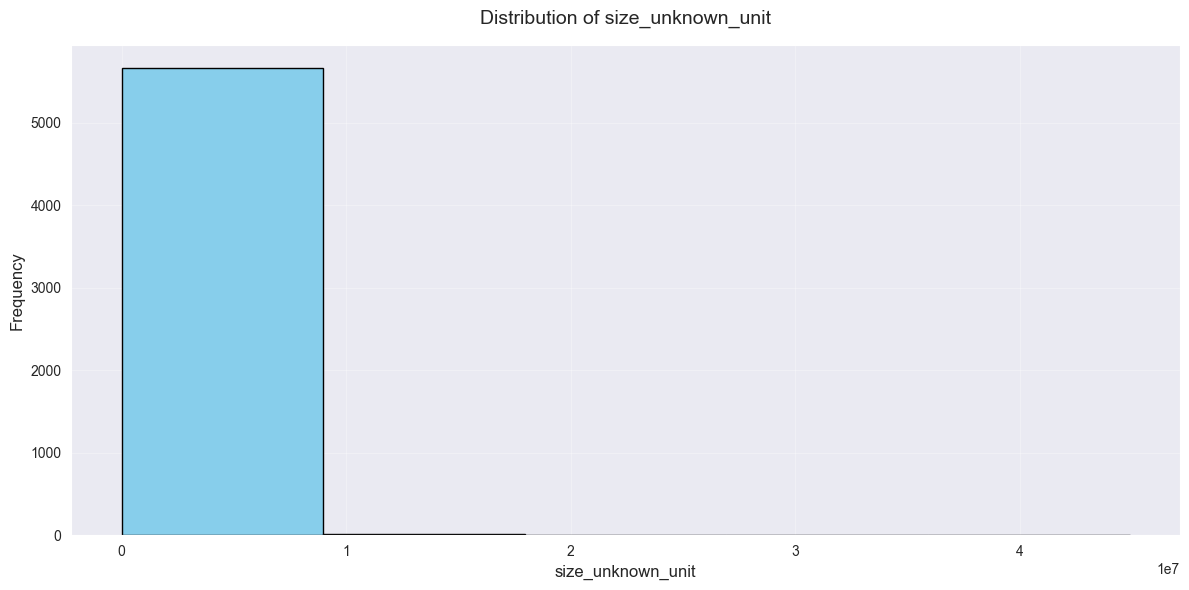

In [46]:
plot_numeric_distribution(num_df, 'size_unknown_unit', 5)

In [47]:
from scipy.stats import zscore

z = zscore(num_df['size_unknown_unit'])
outliers = num_df[abs(z) > 3]  # Threshold of 3 is commo
outliers

,size_unknown_unit,downloads,price_if_paid,reviews_count_numerical,month,day,weekday,quarter,min_base_os_version,Y,app_name
183,17712922,40000000,0,500000000,8,2,3,3,4.0,4.5,UC Browser - Fast Download Private & Secure
731,4578476,24000000,0,50000000,7,17,1,3,4.1,4.6,Castle Clash: Heroes of the Empire US
765,10055521,94000000,0,100000000,6,28,3,2,4.0,4.5,Yes day
1209,7594559,34000000,0,100000000,8,6,0,3,4.0,4.5,PicsArt Photo Studio: Collage Maker & Pic Editor
1385,5783441,14000000,0,100000000,8,6,0,3,4.0,4.5,"APUS Launcher - Theme, Wallpaper, Hide Apps"
1451,5383971,16000000,0,100000000,8,3,4,3,4.0,4.6,ES File Explorer File Manager
1615,8389714,92000000,0,100000000,7,4,2,3,4.0,4.5,Asphalt 8: Airborne
1631,5637451,59000000,0,100000000,8,3,4,3,4.1,4.4,Tik Tok - including musical.ly
1643,4487182,55000000,0,50000000,7,4,2,3,4.0,4.5,Pixel Gun 3D: Survival shooter & Battle Royale
1646,10053186,94000000,0,100000000,6,28,3,2,4.0,4.5,Hay Day


In [48]:
Q1 = num_df['size_unknown_unit'].quantile(0.25)
Q3 = num_df['size_unknown_unit'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = num_df[(num_df['size_unknown_unit'] < lower_bound) | (num_df['size_unknown_unit'] > upper_bound)]
outliers

,size_unknown_unit,downloads,price_if_paid,reviews_count_numerical,month,day,weekday,quarter,min_base_os_version,Y,app_name
0,87510,8700000,0,5000000,8,1,2,3,4.0,4.7,"U Launcher Lite – FREE Live Cool Themes, Hide ..."
10,194216,39000000,0,5000000,8,3,4,3,4.0,4.3,FlipaClip - Cartoon animation
26,174531,24000000,0,10000000,7,31,1,3,4.1,4.7,"Canva: Poster, banner, card maker & graphic de..."
43,116986,35000000,0,5000000,8,2,3,3,4.0,4.8,Fines of the State Traffic Safety Inspectorate...
45,271920,16000000,0,10000000,7,11,2,3,5.0,4.2,"Android Auto - Maps, Media, Messaging & Voice"
...,...,...,...,...,...,...,...,...,...,...,...
5670,736844,20000000,0,10000000,1,19,4,1,4.1,4.5,WWE
5671,3882670,57000000,0,100000000,7,26,3,3,4.1,4.6,Angry Birds 2
5672,181927,18000000,0,10000000,7,27,4,3,4.1,4.6,TED
5673,807246,93000000,0,10000000,7,30,0,3,4.0,4.6,Choices: Stories You Play


<Axes: xlabel='size_unknown_unit'>

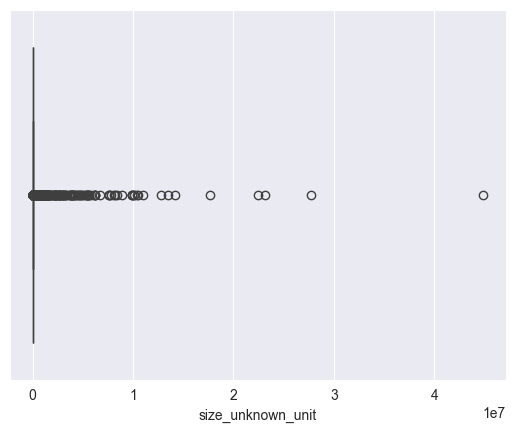

In [49]:
import seaborn as sns

sns.boxplot(x=num_df['size_unknown_unit'])

In [50]:
from sklearn.ensemble import IsolationForest, RandomForestRegressor

model = IsolationForest(contamination=0.01)
num_df['outlier'] = model.fit_predict(num_df[['size_unknown_unit']])  # -1 = outlier, 1 = inlier
num_df[num_df['outlier'] == -1]

,size_unknown_unit,downloads,price_if_paid,reviews_count_numerical,month,day,weekday,quarter,min_base_os_version,Y,app_name,outlier
183,17712922,40000000,0,500000000,8,2,3,3,4.0,4.5,UC Browser - Fast Download Private & Secure,-1
731,4578476,24000000,0,50000000,7,17,1,3,4.1,4.6,Castle Clash: Heroes of the Empire US,-1
765,10055521,94000000,0,100000000,6,28,3,2,4.0,4.5,Yes day,-1
1209,7594559,34000000,0,100000000,8,6,0,3,4.0,4.5,PicsArt Photo Studio: Collage Maker & Pic Editor,-1
1385,5783441,14000000,0,100000000,8,6,0,3,4.0,4.5,"APUS Launcher - Theme, Wallpaper, Hide Apps",-1
1451,5383971,16000000,0,100000000,8,3,4,3,4.0,4.6,ES File Explorer File Manager,-1
1615,8389714,92000000,0,100000000,7,4,2,3,4.0,4.5,Asphalt 8: Airborne,-1
1631,5637451,59000000,0,100000000,8,3,4,3,4.1,4.4,Tik Tok - including musical.ly,-1
1643,4487182,55000000,0,50000000,7,4,2,3,4.0,4.5,Pixel Gun 3D: Survival shooter & Battle Royale,-1
1646,10053186,94000000,0,100000000,6,28,3,2,4.0,4.5,Hay Day,-1


* We will try setting to log
* And try removing them

In [52]:
num_df['log_size'] = np.log1p(num_df['size_unknown_unit'])
num_df_test = num_df[num_df['outlier'] != -1]

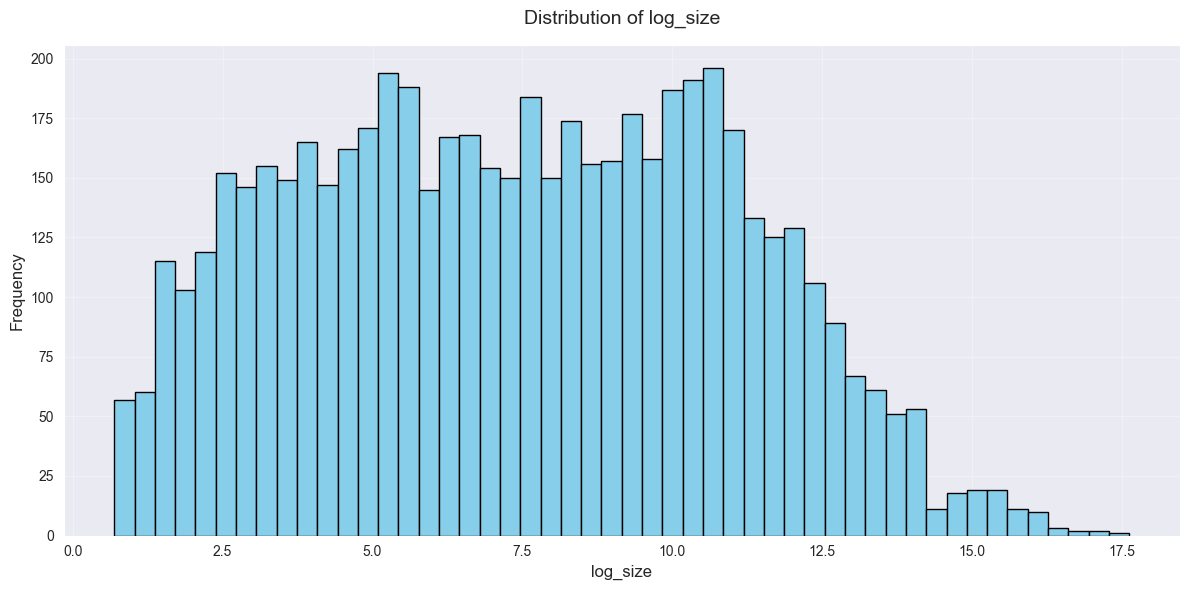

In [53]:
plot_numeric_distribution(num_df, 'log_size')

* Stick with this for now

<Axes: xlabel='log_size'>

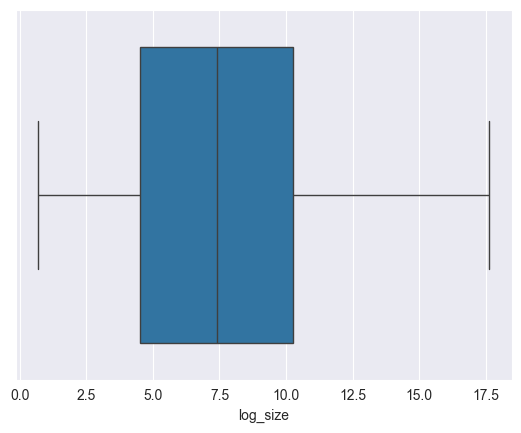

In [55]:
sns.boxplot(x=num_df['log_size'])

### Downloads

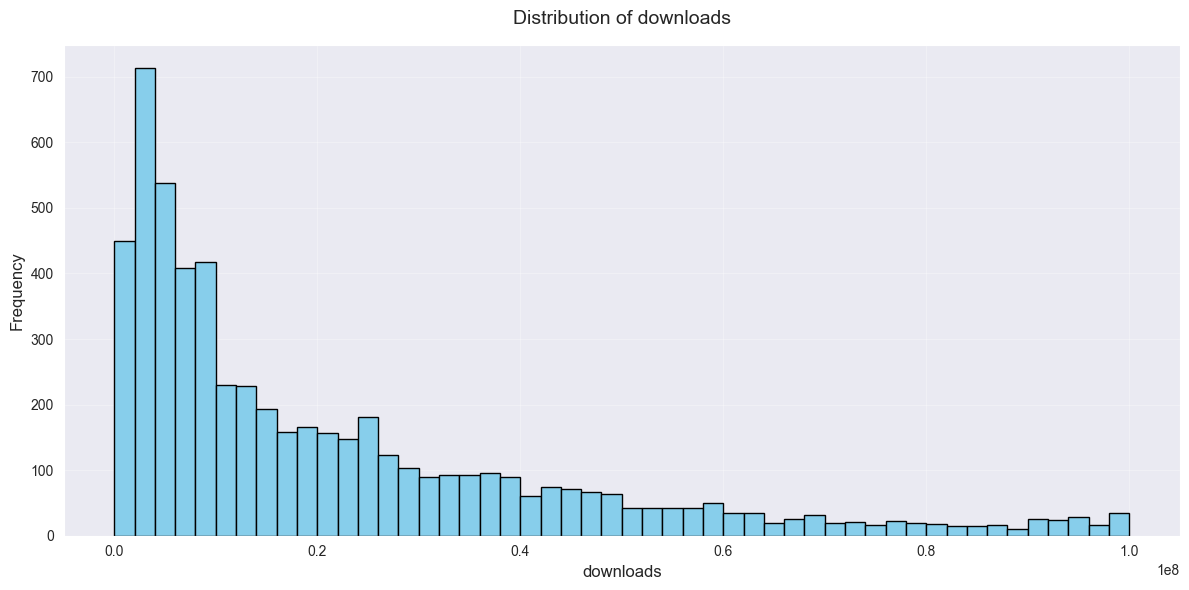

In [56]:
plot_numeric_distribution(num_df, 'downloads')

<Axes: xlabel='downloads'>

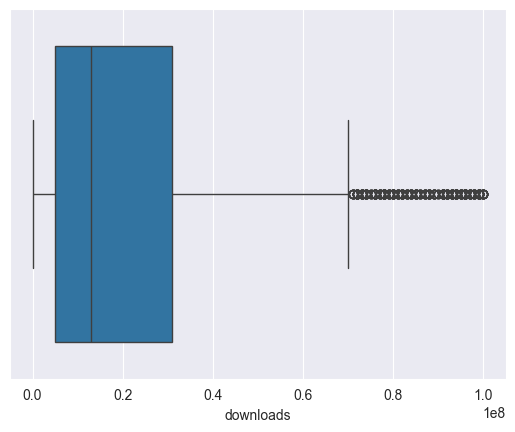

In [58]:
sns.boxplot(x=num_df['downloads'])

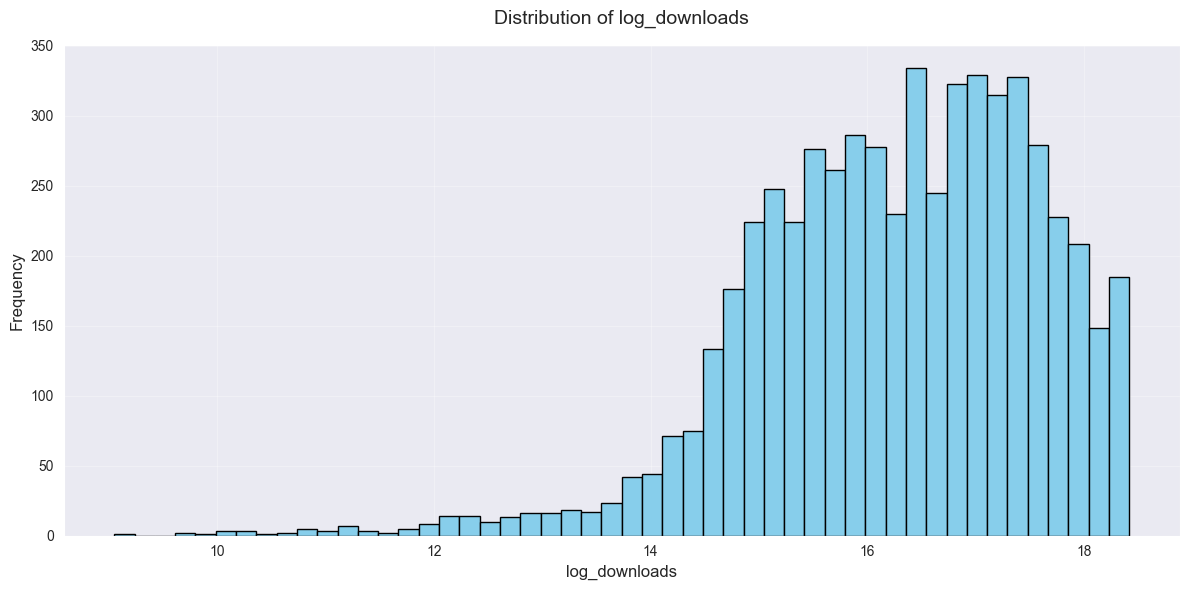

<Axes: xlabel='log_downloads'>

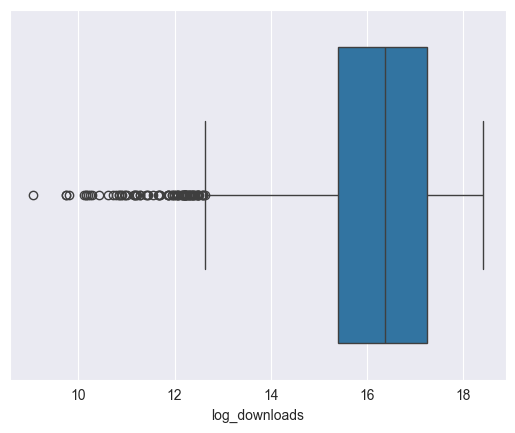

In [60]:
num_df['log_downloads'] = np.log1p(num_df['downloads'])
plot_numeric_distribution(num_df, 'log_downloads')
sns.boxplot(x=num_df['log_downloads'])

In [61]:
from scipy.stats import skew

skew(num_df['downloads'])

1.4966855271290433

In [62]:
skew(num_df['log_downloads'])

-0.8549135133435922

In [65]:
from scipy.stats import boxcox

num_df['sqrt_downloads'] = np.sqrt(num_df['downloads'])
num_df['downloads_boxcox'], lam = boxcox(num_df['downloads'])
print("Skew after Box-Cox:", skew(num_df['downloads_boxcox']))
print("Skew after sqrt:", skew(num_df['sqrt_downloads']))

Skew after Box-Cox: -0.04115537629746412
Skew after sqrt: 0.6393599516868896


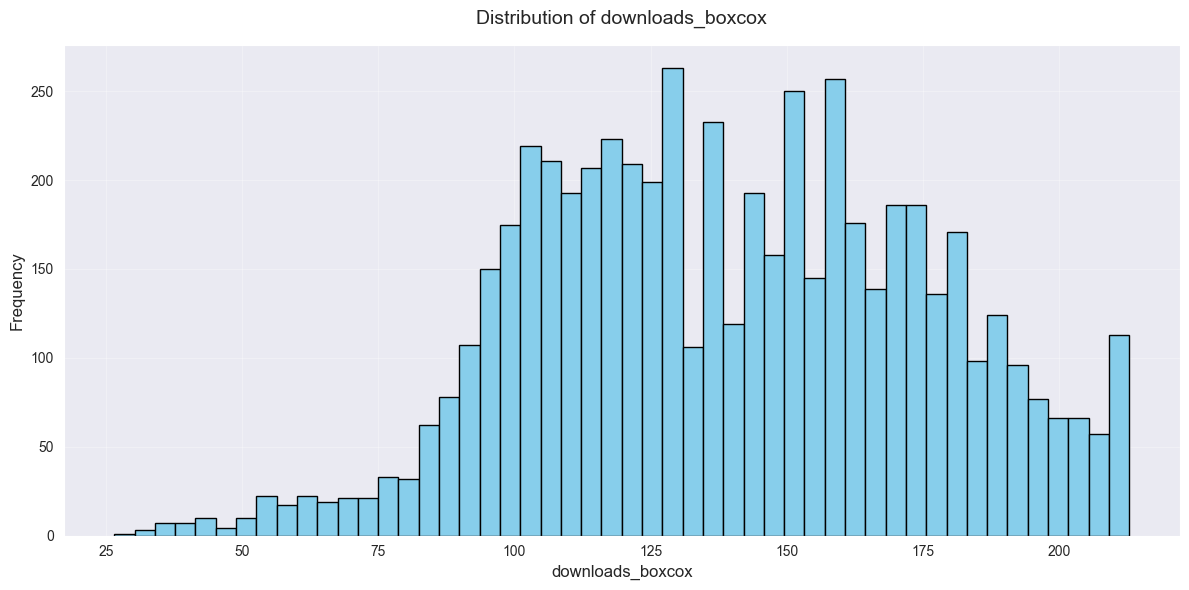

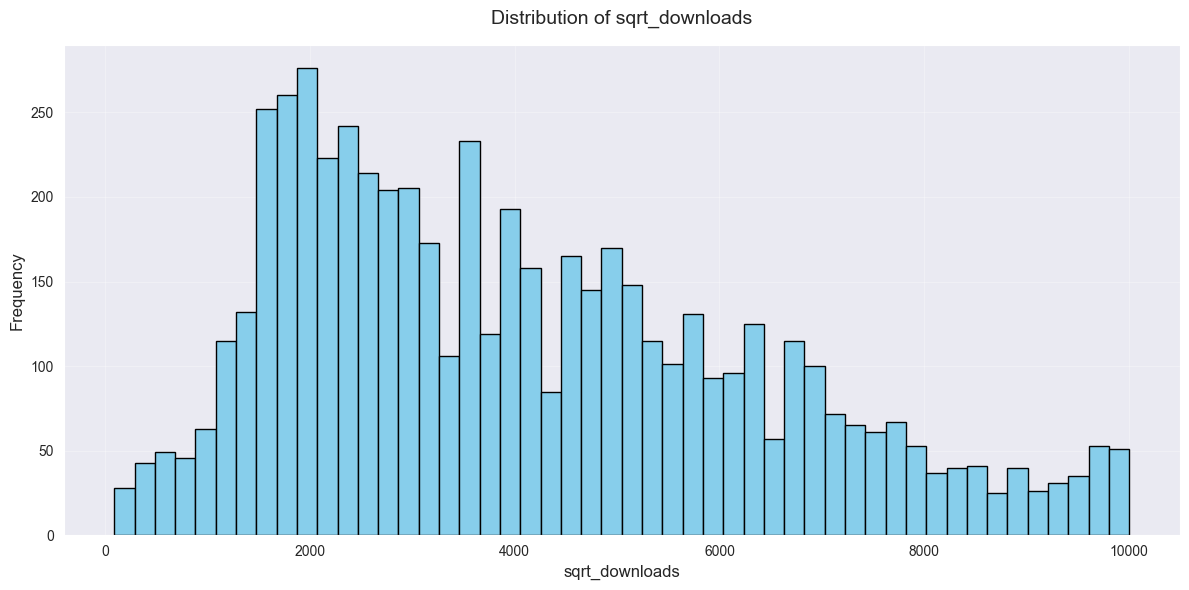

In [66]:
plot_numeric_distribution(num_df, 'downloads_boxcox')
plot_numeric_distribution(num_df, 'sqrt_downloads')

<Axes: xlabel='downloads_boxcox'>

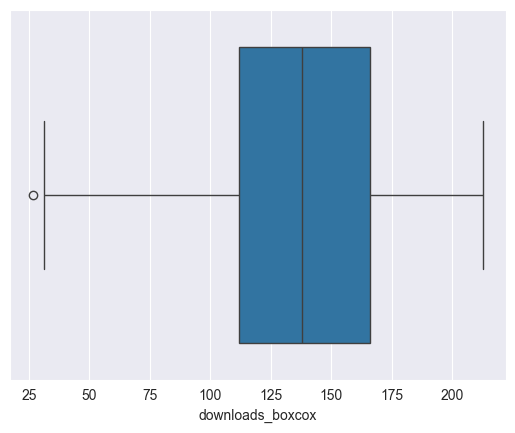

In [67]:
sns.boxplot(x=num_df.downloads_boxcox)

<Axes: xlabel='sqrt_downloads'>

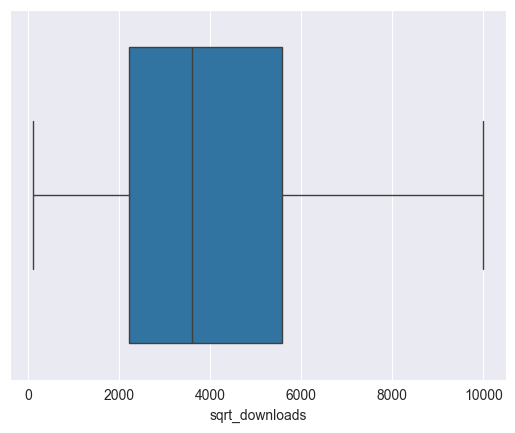

In [68]:
sns.boxplot(x=num_df.sqrt_downloads)

### price, reviews count

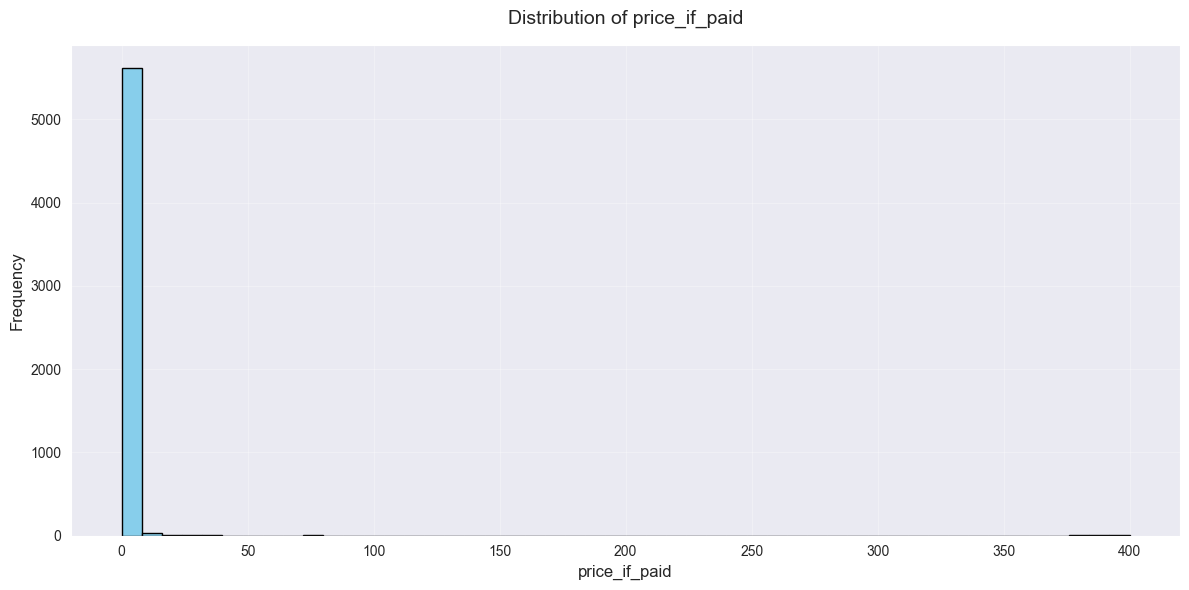

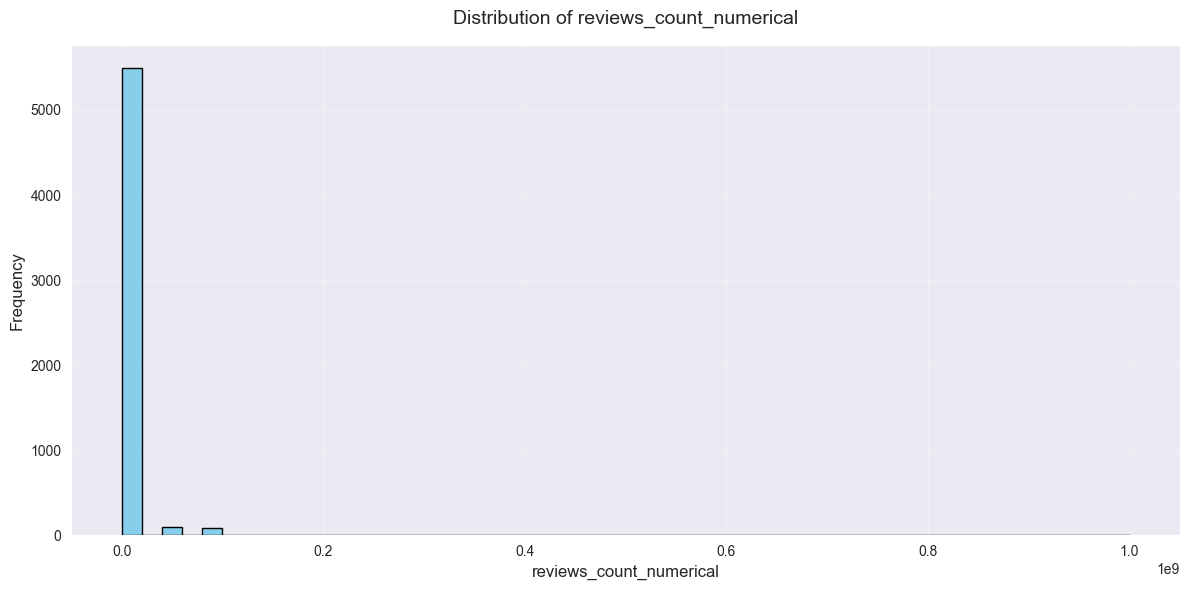

In [69]:
plot_numeric_distribution(num_df, 'price_if_paid')
plot_numeric_distribution(num_df, 'reviews_count_numerical')

In [70]:
skew(num_df['price_if_paid'])

23.287530970535634

In [71]:
skew(num_df.reviews_count_numerical)

21.061147601331104

In [73]:
num_df['log_price_paid_only'] = num_df['price_if_paid'].where(cat_df['free_paid'] == 'Paid', 0)
num_df['log_price_paid_only'] = np.log1p(num_df['log_price_paid_only'])

In [75]:
skew(num_df['log_price_paid_only'])

6.861632135503323

In [80]:
num_df['log_reviews_count'] = np.log1p(num_df['reviews_count_numerical'])
skew(num_df['log_reviews_count'])

-0.23556455286279782

### month, day, weekday, quarter

In [82]:
print(skew(num_df.month))
print(skew(num_df.day))
print(skew(num_df.weekday))
print(skew(num_df.quarter))

-0.035804240527076855
0.0037707606015913078
0.27397698646396706
-0.1901876337418798


### Os min version

In [84]:
skew(num_df['min_base_os_version'])

-0.5477013210405626

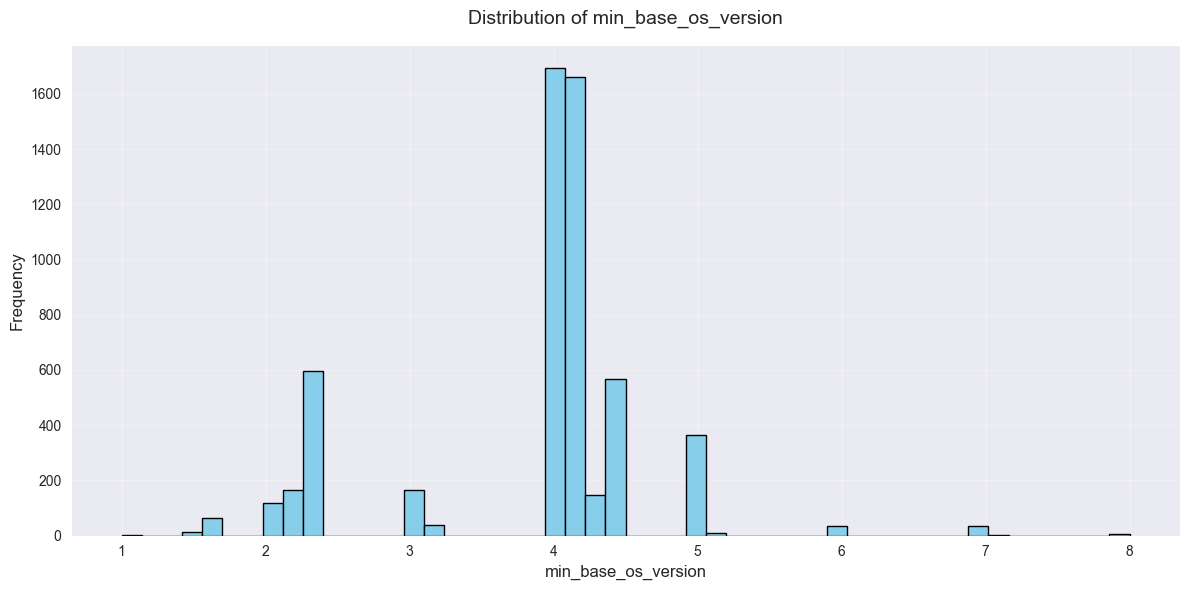

In [85]:
plot_numeric_distribution(num_df, 'min_base_os_version')

<Axes: ylabel='min_base_os_version'>

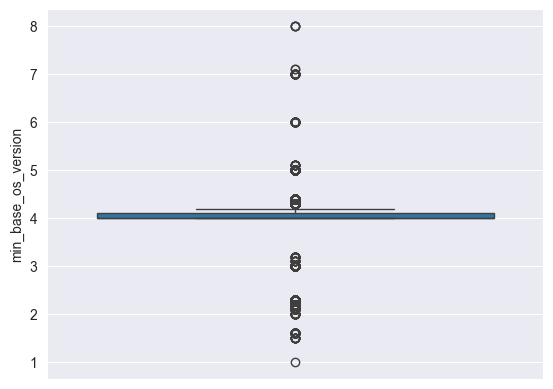

In [86]:
sns.boxplot(num_df['min_base_os_version'])

In [87]:
num_df.drop(columns=['outlier', 'app_name'], inplace=True)

,size_unknown_unit,downloads,price_if_paid,reviews_count_numerical,month,day,weekday,quarter,min_base_os_version,Y,app_name,outlier,log_size,log_downloads,sqrt_downloads,downloads_boxcox,log_price_paid_only,log_reviews_count
122,14760,8600000,0,50000000,1,31,2,1,7.0,3.8,Secure Folder,-1,9.599744,15.967273,2932.575660,126.302827,0.000000,17.727534
642,237,8500,0,50000,9,27,2,3,7.1,4.6,Essential Resources,-1,5.472271,9.047939,92.195445,26.548835,0.000000,10.819798
665,100,7100000,0,1000000,5,9,2,2,7.0,4.5,ZenUI Safeguard,-1,4.615121,15.775605,2664.582519,121.210246,0.000000,13.815512
667,985,16000000,0,500000,5,31,3,2,7.0,4.3,FOSSIL Q: DESIGN YOUR DIAL,-1,6.893656,16.588099,4000.000000,144.253772,0.000000,13.122365
997,197,20000000,0,10000,8,2,3,3,7.0,4.4,Open Sesame - Touch Free Control,-1,5.288267,16.811243,4472.135955,151.289557,0.000000,9.210440
1166,3492,17000000,0,5000000,6,14,3,2,7.0,3.3,Moto Photo Editor,-1,8.158516,16.648724,4123.105626,146.133301,0.000000,15.424949
1315,308,4300000,0,1000000,6,8,4,2,8.0,4.6,Moto Suggestions ™,-1,5.733341,15.274126,2073.644135,108.802123,0.000000,13.815512
1319,12215,9100000,0,5000000,8,1,2,3,7.0,4.4,Nokia mobile support,-1,9.410502,16.023785,3016.620626,127.843257,0.000000,15.424949
1321,9602,2500000,0,100000000,7,5,3,3,7.0,4.4,Samsung Calculator,-1,9.169831,14.731802,1581.138830,96.754335,0.000000,18.420681
1325,315,4600000,0,500000,7,27,4,3,8.0,3.7,Google Assistant Go,-1,5.755742,15.341567,2144.761059,110.396942,0.000000,13.122365


In [89]:
num_df.corr(numeric_only=True)['Y'].sort_values(ascending=False)

Y                          1.000000
log_size                   0.174056
log_reviews_count          0.076998
log_downloads              0.076217
downloads_boxcox           0.074231
sqrt_downloads             0.070555
size_unknown_unit          0.069133
downloads                  0.066510
min_base_os_version        0.049777
reviews_count_numerical    0.048533
weekday                    0.043092
quarter                    0.022014
outlier                    0.013141
log_price_paid_only        0.012004
month                      0.008423
day                       -0.007406
price_if_paid             -0.025488
Name: Y, dtype: float64

In [90]:
num_df_new = num_df.drop(columns=[
    'app_name', 'size_unknown_unit', 'downloads', 'price_if_paid', 'reviews_count_numerical', 'month', 'day', 'outlier',
    'downloads_boxcox', 'sqrt_downloads',
])

In [91]:
num_df_new

,weekday,quarter,min_base_os_version,Y,log_size,log_downloads,log_price_paid_only,log_reviews_count
0,2,3,4.0,4.7,11.379520,15.978834,0.000000,15.424949
1,2,2,4.4,4.3,6.875232,14.845130,0.000000,11.512935
2,6,1,2.3,4.4,5.123964,15.538277,0.000000,10.819798
3,3,2,4.0,3.8,5.187386,16.759950,0.000000,10.819798
4,3,2,4.2,4.1,10.513688,17.182806,0.000000,13.815512
...,...,...,...,...,...,...,...,...
5672,4,3,4.1,4.6,12.111366,16.705882,0.000000,16.118096
5673,0,3,4.0,4.6,13.601385,18.348110,0.000000,16.118096
5674,4,3,4.4,4.7,10.344738,16.993564,1.386294,13.122365
5675,3,3,4.4,4.7,9.012499,16.993564,0.000000,13.122365


## Categorical

In [92]:
cat_df.nunique()


app_category             33
reviews_count            19
free_paid                 2
age_rating                6
year                      9
month                    12
day                      31
weekday                   7
quarter                   4
is_weekend                2
is_month_start            2
is_month_end              2
week_of_year             53
is_holiday_season         2
is_holiday                2
holiday_name             13
min_base_os_version      21
is_wear_os                2
is_version_range          2
app_name               5665
dtype: int64

In [94]:
threshold = 0.01  # 1% of total
for col in cat_df.columns:
    freqs = cat_df[col].value_counts(normalize=True)
    rare = freqs[freqs < threshold]
    if not rare.empty:
        print(f"{col} has rare values:\n{rare}\n")


app_category has rare values:
app_category
ENTERTAINMENT         0.009864
AUTO_AND_VEHICLES     0.008984
LIBRARIES_AND_DEMO    0.007927
ART_AND_DESIGN        0.007398
HOUSE_AND_HOME        0.007222
WEATHER               0.006694
COMICS                0.005989
EVENTS                0.005284
PARENTING             0.005108
BEAUTY                0.004932
Name: proportion, dtype: float64

reviews_count has rare values:
reviews_count
10+               0.008984
50+               0.008103
500,000,000+      0.001233
5+                0.000881
1+                0.000528
1,000,000,000+    0.000352
Name: proportion, dtype: float64

age_rating has rare values:
age_rating
Adults only 18+    0.000352
Unrated            0.000176
Name: proportion, dtype: float64

year has rare values:
year
2012    0.003171
2011    0.001938
2010    0.000176
Name: proportion, dtype: float64

week_of_year has rare values:
week_of_year
43    0.009864
41    0.009864
38    0.009864
2     0.009512
46    0.009336
49    0.00933

* We should drop week_of_year
* app_category can have less categories by grouping rare occurences into other

In [104]:
cat_df.drop(columns=['week_of_year'], inplace=True)

In [102]:
def check_variation(category_col):
    combined = pd.concat([cat_df[category_col], num_df['Y']], axis=1)
    return combined.groupby(category_col)['Y'].mean().sort_values()


In [103]:
check_variation("is_month_end")

is_month_end
False    4.152707
True     4.199190
Name: Y, dtype: float64

* We can see is_month_end, is_month_start  has little variation between categories
* So we will drop it

In [ ]:
cat_df.drop(columns=['is_month_end', 'is_month_start'], inplace=True)

In [109]:
check_variation("is_weekend")

is_weekend
False    4.147507
True     4.201178
Name: Y, dtype: float64

In [112]:
check_variation("is_holiday")

is_holiday
True     4.154545
False    4.154734
Name: Y, dtype: float64

In [119]:
check_variation('age_rating')

age_rating
Unrated            4.100000
Mature 17+         4.133068
Everyone           4.142888
Teen               4.217107
Everyone 10+       4.243810
Adults only 18+    4.550000
Name: Y, dtype: float64

In [120]:
check_variation('weekday')

weekday
0    4.121124
2    4.136944
1    4.144716
5    4.163524
4    4.165134
3    4.167636
6    4.243213
Name: Y, dtype: float64

In [121]:
check_variation('year')

year
2012    3.755556
2016    4.011957
2011    4.036364
2014    4.042568
2015    4.047703
2017    4.068505
2013    4.105970
2010    4.200000
2018    4.214562
Name: Y, dtype: float64

In [123]:
def group_years(year):
    if year <= 2012:
        return 'Old'
    elif 2013 <= year <= 2016:
        return 'Middle'
    else:
        return 'Recent'


cat_df['year_group'] = cat_df['year'].apply(group_years)
check_variation('year_group')

year_group
Old       3.873333
Middle    4.033820
Recent    4.181233
Name: Y, dtype: float64

In [122]:
check_variation('month')

month
10    4.002083
9     4.026630
12    4.031915
2     4.071336
3     4.084715
4     4.105217
11    4.105769
5     4.117304
1     4.137918
6     4.171809
7     4.227438
8     4.254339
Name: Y, dtype: float64

In [125]:
check_variation('quarter')

quarter
4    4.043924
1    4.095322
2    4.138892
3    4.220000
Name: Y, dtype: float64

In [127]:
check_variation('holiday_name')

holiday_name
Christmas Day                 3.830000
Washington's Birthday         3.875000
Labor Day                     4.000000
New Year's Day                4.016667
Martin Luther King Jr. Day    4.045455
Veterans Day (observed)       4.050000
Columbus Day                  4.110000
Not Holiday                   4.154734
Christmas Day (observed)      4.200000
Memorial Day                  4.212000
Thanksgiving Day              4.212500
Veterans Day                  4.250000
Independence Day              4.333333
Name: Y, dtype: float64

In [128]:
def group_holidays(holiday):
    high = [
        "Independence Day", "Veterans Day", "Thanksgiving Day",
        "Memorial Day", "Christmas Day (observed)"
    ]
    mid = [
        "Not Holiday", "Columbus Day", "Martin Luther King Jr. Day",
        "Veterans Day (observed)", "New Year's Day", "Labor Day"
    ]
    low = [
        "Christmas Day", "Washington's Birthday"
    ]

    if holiday in high:
        return "High Rating Holiday"
    elif holiday in mid:
        return "Mid Rating Holiday"
    elif holiday in low:
        return "Low Rating Holiday"
    else:
        return "Other"


cat_df['holiday_group'] = cat_df['holiday_name'].apply(group_holidays)
check_variation('holiday_group')

holiday_group
Low Rating Holiday     3.842857
Mid Rating Holiday     4.154095
High Rating Holiday    4.266197
Name: Y, dtype: float64

In [129]:
check_variation('reviews_count')

reviews_count
5,000+            3.974695
50,000+           4.029118
10,000+           4.030191
1,000+            4.043619
100,000+          4.117027
500,000+          4.162597
500+              4.163158
1,000,000,000+    4.200000
1,000,000+        4.217865
5,000,000+        4.241240
10,000,000+       4.291493
5+                4.300000
50,000,000+       4.308511
100+              4.344304
50+               4.373913
100,000,000+      4.384524
500,000,000+      4.385714
10+               4.650980
1+                5.000000
Name: Y, dtype: float64

In [130]:
def group_reviews_count(val):
    very_low = ["1+", "5+", "10+", "50+", "100+"]
    low_mid = ["500+", "1,000+", "5,000+", "10,000+", "50,000+"]
    mid = ["100,000+", "500,000+"]
    high = ["1,000,000+", "5,000,000+", "10,000,000+"]
    top = ["50,000,000+", "100,000,000+", "500,000,000+", "1,000,000,000+"]

    if val in very_low:
        return "Very Low"
    elif val in low_mid:
        return "Low-Mid"
    elif val in mid:
        return "Mid"
    elif val in high:
        return "High"
    elif val in top:
        return "Top Tier"
    else:
        return "Other"


cat_df['reviews_group'] = cat_df['reviews_count'].apply(group_reviews_count)
check_variation('reviews_group')

reviews_group
Low-Mid     4.034272
Mid         4.131997
High        4.243662
Top Tier    4.344385
Very Low    4.399123
Name: Y, dtype: float64

In [131]:
check_variation('min_base_os_version')

min_base_os_version
8.0    3.875000
4.3    3.898630
6.0    3.944444
2.2    3.947273
3.1    3.962500
3.2    3.968966
1.5    4.036364
1.6    4.046154
2.3    4.074118
3.0    4.079394
7.0    4.083333
4.4    4.117989
2.1    4.136957
5.0    4.155342
4.2    4.172840
4.0    4.197992
7.1    4.200000
4.1    4.222708
5.1    4.240000
2.0    4.365385
1.0    4.500000
Name: Y, dtype: float64

In [132]:
check_variation('app_category')

app_category
TRAVEL_AND_LOCAL       3.969091
TOOLS                  3.999029
VIDEO_PLAYERS          4.001124
DATING                 4.001942
MAPS_AND_NAVIGATION    4.014103
COMMUNICATION          4.070370
LIFESTYLE              4.082075
PHOTOGRAPHY            4.087429
FOOD_AND_DRINK         4.094828
BUSINESS               4.098895
FINANCE                4.100000
HOUSE_AND_HOME         4.114634
AUTO_AND_VEHICLES      4.123529
NEWS_AND_MAGAZINES     4.133582
PRODUCTIVITY           4.136047
ENTERTAINMENT          4.142857
MEDICAL                4.148472
HEALTH_AND_FITNESS     4.170625
FAMILY                 4.173344
LIBRARIES_AND_DEMO     4.180000
SOCIAL                 4.208527
SPORTS                 4.210674
SHOPPING               4.216393
GAME                   4.237389
COMICS                 4.255882
BEAUTY                 4.264286
WEATHER                4.286842
PARENTING              4.334483
PERSONALIZATION        4.337557
BOOKS_AND_REFERENCE    4.342857
ART_AND_DESIGN         4.36

app_category_grouped
TRAVEL_AND_LOCAL       3.969091
TOOLS                  3.999029
VIDEO_PLAYERS          4.001124
DATING                 4.001942
MAPS_AND_NAVIGATION    4.014103
COMMUNICATION          4.070370
LIFESTYLE              4.082075
PHOTOGRAPHY            4.087429
FOOD_AND_DRINK         4.094828
BUSINESS               4.098895
FINANCE                4.100000
NEWS_AND_MAGAZINES     4.133582
PRODUCTIVITY           4.136047
MEDICAL                4.148472
HEALTH_AND_FITNESS     4.170625
FAMILY                 4.173344
SOCIAL                 4.208527
SPORTS                 4.210674
SHOPPING               4.216393
Other                  4.234772
GAME                   4.237389
PERSONALIZATION        4.337557
BOOKS_AND_REFERENCE    4.342857
EDUCATION              4.408955
Name: Y, dtype: float64

In [134]:
cat_df.nunique()

app_category              33
reviews_count             19
free_paid                  2
age_rating                 6
year                       9
month                     12
day                       31
weekday                    7
quarter                    4
is_weekend                 2
is_holiday_season          2
is_holiday                 2
holiday_name              13
min_base_os_version       21
is_wear_os                 2
is_version_range           2
app_name                5665
year_group                 3
holiday_group              3
reviews_group              5
app_category_grouped      24
dtype: int64

* drop is weekend is holiday, weekday, month

In [135]:
cat_df.drop(columns=['is_weekend', 'is_holiday', 'weekday', 'month'], inplace=True)

In [136]:
cat_df.nunique()

app_category              33
reviews_count             19
free_paid                  2
age_rating                 6
year                       9
day                       31
quarter                    4
is_holiday_season          2
holiday_name              13
min_base_os_version       21
is_wear_os                 2
is_version_range           2
app_name                5665
year_group                 3
holiday_group              3
reviews_group              5
app_category_grouped      24
dtype: int64

* drop day, min_base_os_version, reviews_count, holiday_name

In [137]:
cat_df.drop(columns=['day', 'min_base_os_version', 'reviews_count', 'holiday_name'], inplace=True)

In [138]:
cat_df.nunique()

app_category              33
free_paid                  2
age_rating                 6
year                       9
quarter                    4
is_holiday_season          2
is_wear_os                 2
is_version_range           2
app_name                5665
year_group                 3
holiday_group              3
reviews_group              5
app_category_grouped      24
dtype: int64

In [141]:
check_variation('is_wear_os')

is_wear_os
False    4.154549
True     4.360000
Name: Y, dtype: float64

In [142]:
check_variation('is_version_range')

is_version_range
False    4.154541
True     4.333333
Name: Y, dtype: float64

In [144]:
check_variation('free_paid')

free_paid
Free    4.146902
Paid    4.249769
Name: Y, dtype: float64

* drop year, is_holiday_season, app_category_grouped

In [145]:
cat_df.drop(columns=['year', 'is_holiday_season', 'app_category_grouped'], inplace=True)

In [146]:
cat_df.nunique()

app_category          33
free_paid              2
age_rating             6
quarter                4
is_wear_os             2
is_version_range       2
app_name            5665
year_group             3
holiday_group          3
reviews_group          5
dtype: int64

In [147]:
num_df_new.nunique()

weekday                   7
quarter                   4
min_base_os_version      21
Y                        39
log_size               3603
log_downloads           365
log_price_paid_only      30
log_reviews_count        19
dtype: int64

In [148]:
num_df_new.drop(columns=['quarter'], inplace=True)

In [150]:

combined_df = cat_df.join(num_df_new)
combined_df

,app_category,free_paid,age_rating,quarter,is_wear_os,is_version_range,app_name,year_group,holiday_group,reviews_group,weekday,min_base_os_version,Y,log_size,log_downloads,log_price_paid_only,log_reviews_count
0,ART_AND_DESIGN,Free,Everyone,3,False,False,"U Launcher Lite – FREE Live Cool Themes, Hide ...",Recent,Mid Rating Holiday,High,2,4.0,4.7,11.379520,15.978834,0.000000,15.424949
1,ART_AND_DESIGN,Free,Everyone,2,False,False,Pixel Draw - Number Art Coloring Book,Recent,Mid Rating Holiday,Mid,2,4.4,4.3,6.875232,14.845130,0.000000,11.512935
2,ART_AND_DESIGN,Free,Everyone,1,False,False,Paper flowers instructions,Recent,Mid Rating Holiday,Low-Mid,6,2.3,4.4,5.123964,15.538277,0.000000,10.819798
3,ART_AND_DESIGN,Free,Everyone,2,False,False,Smoke Effect Photo Maker - Smoke Editor,Recent,Mid Rating Holiday,Low-Mid,3,4.0,3.8,5.187386,16.759950,0.000000,10.819798
4,ART_AND_DESIGN,Free,Everyone,2,False,False,Infinite Painter,Recent,Mid Rating Holiday,High,3,4.2,4.1,10.513688,17.182806,0.000000,13.815512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,EDUCATION,Free,Everyone 10+,3,False,False,TED,Recent,Mid Rating Holiday,High,4,4.1,4.6,12.111366,16.705882,0.000000,16.118096
5673,GAME,Free,Teen,3,False,False,Choices: Stories You Play,Recent,Mid Rating Holiday,High,0,4.0,4.6,13.601385,18.348110,0.000000,16.118096
5674,EDUCATION,Paid,Everyone,3,False,False,Toca Life: City,Recent,Mid Rating Holiday,Mid,4,4.4,4.7,10.344738,16.993564,1.386294,13.122365
5675,ART_AND_DESIGN,Free,Everyone,3,False,False,UNICORN - Color By Number & Pixel Art Coloring,Recent,Mid Rating Holiday,Mid,3,4.4,4.7,9.012499,16.993564,0.000000,13.122365


In [151]:
combined_df.to_csv('first_combined_df.csv', index=False)

In [152]:
combined_df.drop(columns=['app_name'], inplace=True)

In [153]:
combined_df.dtypes

app_category            object
free_paid               object
age_rating              object
quarter                  int64
is_wear_os                bool
is_version_range          bool
year_group              object
holiday_group           object
reviews_group           object
weekday                  int64
min_base_os_version    float64
Y                      float64
log_size               float64
log_downloads          float64
log_price_paid_only    float64
log_reviews_count      float64
dtype: object

In [200]:
combined_df

,app_category,free_paid,age_rating,quarter,is_wear_os,is_version_range,year_group,holiday_group,reviews_group,weekday,min_base_os_version,Y,log_size,log_downloads,log_price_paid_only,log_reviews_count
0,ART_AND_DESIGN,Free,Everyone,3,False,False,Recent,Mid Rating Holiday,High,2,4.0,4.7,11.379520,15.978834,0.000000,15.424949
1,ART_AND_DESIGN,Free,Everyone,2,False,False,Recent,Mid Rating Holiday,Mid,2,4.4,4.3,6.875232,14.845130,0.000000,11.512935
2,ART_AND_DESIGN,Free,Everyone,1,False,False,Recent,Mid Rating Holiday,Low-Mid,6,2.3,4.4,5.123964,15.538277,0.000000,10.819798
3,ART_AND_DESIGN,Free,Everyone,2,False,False,Recent,Mid Rating Holiday,Low-Mid,3,4.0,3.8,5.187386,16.759950,0.000000,10.819798
4,ART_AND_DESIGN,Free,Everyone,2,False,False,Recent,Mid Rating Holiday,High,3,4.2,4.1,10.513688,17.182806,0.000000,13.815512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,EDUCATION,Free,Everyone 10+,3,False,False,Recent,Mid Rating Holiday,High,4,4.1,4.6,12.111366,16.705882,0.000000,16.118096
5673,GAME,Free,Teen,3,False,False,Recent,Mid Rating Holiday,High,0,4.0,4.6,13.601385,18.348110,0.000000,16.118096
5674,EDUCATION,Paid,Everyone,3,False,False,Recent,Mid Rating Holiday,Mid,4,4.4,4.7,10.344738,16.993564,1.386294,13.122365
5675,ART_AND_DESIGN,Free,Everyone,3,False,False,Recent,Mid Rating Holiday,Mid,3,4.4,4.7,9.012499,16.993564,0.000000,13.122365


* LinearRegression()
* RandomForestRegressor()
* XGBRegressor()
* GradientBoostingRegressor()

In [201]:
y = combined_df[['Y']]
X = combined_df.drop(columns=['Y'])

In [204]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = make_column_transformer(
    (cat_pipeline, make_column_selector(dtype_include=['object', 'int64'])),
)

In [217]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

model_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor())  # Or XGBRegressor(), etc.
])
model_pipeline.fit(X, y.values.ravel())


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A9E432990>)])),
                ('model', RandomForestRegressor())])

In [218]:
from sklearn.model_selection import KFold, cross_val_score

rmses = -cross_val_score(model_pipeline, X, y.values.ravel(),
                         scoring="neg_mean_squared_error", cv=10)

pd.Series(rmses).describe()

count    10.000000
mean      0.356069
std       0.116423
min       0.155354
25%       0.284485
50%       0.380276
75%       0.427244
max       0.508867
dtype: float64

In [226]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'model__max_features': randint(low=2, high=20)}
rnd_search = RandomizedSearchCV(
    model_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X, y.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('pipeline',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000028A9E432990>)])),
                                             ('model',
                                              RandomForestRegressor())]),
                   param_distributions={'model__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000028A805DF230>},
                   random_state=42, scoring='neg_mean_squared_error')

In [228]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["model"].feature_importances_
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.043910401926915386, 'pipeline__reviews_group_Low-Mid'),
 (0.041962159491874866, 'pipeline__weekday_0'),
 (0.04081818405288713, 'pipeline__weekday_1'),
 (0.03875118928713453, 'pipeline__weekday_2'),
 (0.03763403874806222, 'pipeline__weekday_3'),
 (0.036970777815338106, 'pipeline__weekday_4'),
 (0.035336896962936674, 'pipeline__quarter_2'),
 (0.03518871043699676, 'pipeline__reviews_group_Very Low'),
 (0.03390867372526151, 'pipeline__app_category_FAMILY'),
 (0.03158497203566696, 'pipeline__quarter_1'),
 (0.030970892685473768, 'pipeline__quarter_3'),
 (0.027063910062189115, 'pipeline__app_category_TOOLS'),
 (0.02654125751528226, 'pipeline__app_category_MEDICAL'),
 (0.02618645003632057, 'pipeline__quarter_4'),
 (0.024410681360821643, 'pipeline__weekday_5'),
 (0.02290677153106107, 'pipeline__app_category_HEALTH_AND_FITNESS'),
 (0.02218872048144627, 'pipeline__reviews_group_Mid'),
 (0.02180466063406318, 'pipeline__reviews_group_High'),
 (0.02079056795413113, 'pipeline__year_group_Recent')

In [220]:
test_df = pd.read_csv("app-rating-competition/test.csv")

In [221]:
test_df

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
0,Girls hairstyles 2018,BEAUTY,62,3.1M,"10,000+",Free,0,Everyone,Beauty,"May 28, 2018",1.9.2,4.0.3 and up
1,Dairy Queen,FOOD_AND_DRINK,742,43M,"100,000+",Free,0,Everyone,Food & Drink,"July 25, 2018",2.1.0,4.1 and up
2,Remote Control For All AC - Universal Remote,PRODUCTIVITY,166,6.1M,"10,000+",Free,0,Everyone,Productivity,"July 28, 2018",1.1,4.0.3 and up
3,Ultimate Chest Tracker,PRODUCTIVITY,40328,23M,"1,000,000+",Free,0,Everyone,Productivity,"October 17, 2016",1.9,2.3 and up
4,Mobilight-BM,FINANCE,6,6.2M,500+,Free,0,Everyone,Finance,"August 3, 2018",2.0.10,4.0.3 and up
...,...,...,...,...,...,...,...,...,...,...,...,...
1868,FREE Stock Market Trading Tips,FINANCE,714,3.6M,"50,000+",Free,0,Everyone,Finance,"June 7, 2017",2.10.3,2.3.3 and up
1869,Next Portuguese(BR) Langpack,TOOLS,1320,778k,"100,000+",Free,0,Everyone,Tools,"September 13, 2013",1.0,2.0 and up
1870,850 Sports News Digest,SPORTS,539,Varies with device,"10,000+",Free,0,Everyone,Sports,"August 23, 2016",Varies with device,Varies with device
1871,Lite for Facebook Messenger,COMMUNICATION,76498,4.3M,"1,000,000+",Free,0,Teen,Communication,"June 20, 2018",6.3.2,Varies with device
